### 환경 설정

In [2]:
import torch, sys
print("torch version:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)  # None 또는 '11.8','12.1' 등
print("is_available:", torch.cuda.is_available())
print("compiled with cudnn?:", torch.backends.cudnn.is_available())

torch version: 2.7.1+cu118
torch.version.cuda: 11.8
is_available: True
compiled with cudnn?: True


In [ ]:
# === beethoven만 6:2:2로 분리 + flattened_metadata_with_split.json 생성 ===

import os, json, re, math, shutil, glob, random
from pathlib import Path

# --- 경로 설정 ---
PROJ = Path("C:/Users/seon/Downloads/aria-midi-v1-unique-ext").resolve()
DATA_ROOT = PROJ / "data"  # data/aa ~ data/ko 내부 포함 재귀 탐색
META_JSON = PROJ / "metadata.json"

# 출력 폴더 (프로젝트 루트 아래에 생성)
SPLIT_ROOT = PROJ / "chopin_dataset"  # splits/train, splits/validation, splits/test
SPLIT_ROOT.mkdir(parents=True, exist_ok=True)
for sub in ["train", "validation", "test"]:
    (SPLIT_ROOT / sub).mkdir(parents=True, exist_ok=True)

# --- 유틸 ---
def parse_filename(fp: Path):
    """
    '000004_0.mid' -> (id_str='4', take_str='0')
    """
    m = re.match(r"^(\d{6})_(\d+)\.mid$", fp.name)
    if not m:
        return None, None
    id_num = int(m.group(1))
    take = m.group(2)
    return str(id_num), take  # metadata.json의 키는 보통 '4' 처럼 0패딩 없음

def pick_audio_score(meta_entry: dict, take: str):
    """
    audio_scores에서 해당 take 키가 있으면 사용, 없으면 첫 값 사용, 없으면 None
    """
    aud = meta_entry.get("audio_scores", {})
    if isinstance(aud, dict) and aud:
        if take in aud:
            return aud[take]
        # 없으면 첫 번째 값
        try:
            # 키가 문자열일 수 있으므로 정렬 없이 임의 첫 값
            return next(iter(aud.values()))
        except StopIteration:
            return None
    return None

def is_chopin(composer_val):
    if composer_val is None:
        return False
    s = str(composer_val).lower()
    return "chopin" in s  # J.S. beethoven 변형 포함

# --- 메타 로드 ---
assert META_JSON.exists(), f"metadata.json not found: {META_JSON}"
with open(META_JSON, "r") as f:
    meta_raw = json.load(f)

# --- 데이터 스캔: 모든 .mid 파일 ---
all_mid_paths = [Path(p) for p in glob.glob(str(DATA_ROOT / "**" / "*.mid"), recursive=True)]

# --- Beethoven만 필터링 ---
bach_items = []
skipped_no_meta = 0
skipped_bad_name = 0

for fp in all_mid_paths:
    id_str, take = parse_filename(fp)        # ✅ Path 객체를 그대로 넘김
    if not id_str:  # 파일명 형식 불일치
        skipped_bad_name += 1
        continue
    entry = meta_raw.get(id_str)
    if not entry:
        skipped_no_meta += 1
        continue

    md = entry.get("metadata", {})
    composer = md.get("composer")
    if not is_chopin(composer):
        continue

    # 수집 (나중에 split/메타 구성에 활용)
    bach_items.append((fp, id_str, take, entry))

print(f"총 MIDI: {len(all_mid_paths)}개")
print(f"beethoven 후보: {len(bach_items)}개")
print(f"메타 없음으로 스킵: {skipped_no_meta}개, 파일명 규칙 불일치 스킵: {skipped_bad_name}개")

# --- 6:2:2 분할 ---
SEED = 42
random.Random(SEED).shuffle(bach_items)

N = len(bach_items)
n_train = math.floor(N * 0.6)
n_val   = math.floor(N * 0.2)
n_test  = N - n_train - n_val  # 남은 몫

splits = (
    [("train", 0.6)] * n_train +
    [("validation", 0.2)] * n_val +
    [("test", 0.2)] * n_test
)

# --- 복사 & 플래튼 메타 구성 ---
flat_meta = {}  # key: "000004_0.mid" 같은 파일명, val: dict(fields)
missing_optionals = {"music_period": 0, "difficulty": 0, "genre": 0, "opus": 0}

for (item, (split_name, split_ratio)) in zip(bach_items, splits):
    fp, id_str, take, entry = item
    md = entry.get("metadata", {})

    # 대상 파일명(베이스네임)
    basename = fp.name  # 예: 000004_0.mid

    # 오디오 스코어
    audio_score = pick_audio_score(entry, take)

    # 옵션 필드 안전 접근
    music_period = md.get("music_period")
    difficulty   = md.get("difficulty")
    genre        = md.get("genre")
    opus         = md.get("opus")

    if music_period is None: missing_optionals["music_period"] += 1
    if difficulty   is None: missing_optionals["difficulty"]   += 1
    if genre        is None: missing_optionals["genre"]        += 1
    if opus         is None: missing_optionals["opus"]         += 1

    # 목적지에 복사
    dst = SPLIT_ROOT / split_name / basename
    # 같은 이름이 이미 있으면 덮어씀
    shutil.copy2(fp, dst)

    # 평탄화된 레코드
    flat_meta[basename] = {
        "file_path": basename,                 # 반드시 "000004_0.mid" 형식
        "split": split_name,                  # train / validation / test
        "composer": md.get("composer"),
        "music_period": music_period,
        "difficulty": difficulty,
        "genre": genre,
        "audio_score": audio_score,
        "opus": opus,
        "split_ratio": split_ratio,           # 0.6 / 0.2 / 0.2
    }

# --- JSON 저장 ---
OUT_JSON = PROJ / "flattened_metadata_with_split.json"
with open(OUT_JSON, "w") as f:
    json.dump(flat_meta, f, ensure_ascii=False, indent=2)

print("\n=== 분할 결과 ===")
print(f"train: {n_train}, validation: {n_val}, test: {n_test}")
print(f"저장: {OUT_JSON}")
print(f"출력 폴더: {SPLIT_ROOT} (train/ validation/ test)")

# 옵션 필드 결측 요약
print("\n(참고) optional 필드 결측 개수 →",
      {k:v for k,v in missing_optionals.items() if v>0})

총 MIDI: 32522개
beethoven 후보: 471개
메타 없음으로 스킵: 0개, 파일명 규칙 불일치 스킵: 0개

=== 분할 결과 ===
train: 282, validation: 94, test: 95
저장: C:\Users\seon\Downloads\aria-midi-v1-unique-ext\flattened_metadata_with_split.json
출력 폴더: C:\Users\seon\Downloads\aria-midi-v1-unique-ext\chopin_dataset (train/ validation/ test)

(참고) optional 필드 결측 개수 → {'music_period': 75, 'difficulty': 257, 'genre': 5, 'opus': 38}


In [5]:
# [1] 런타임 체크 (CUDA + CPU)
import torch, sys, random, numpy as np

print("Python:", sys.version)
print("CUDA available:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 재현성
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device.type == "cuda":
    torch.cuda.manual_seed_all(seed)

Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
CUDA available: True
Using device: cuda


In [6]:
# [2] 라이브러리
!pip -q install pretty_midi miditoolkit music21 datasets --progress-bar off
# (선택) 시각화/로그: wandb or tensorboard 원하면 추가

^C


In [ ]:
### 음악 샘플 테스트
!apt-get -q install -y fluidsynth
!pip install midi2audio

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxc

In [8]:
PROJ = "C:/Users/seon/Downloads/aria-midi-v1-unique-ext"
print("PROJ:", PROJ)

PROJ: C:/Users/seon/Downloads/aria-midi-v1-unique-ext


In [9]:
import os, glob, json, pandas as pd

# PROJ 하위에서 메타데이터 파일 찾기 (파일명이 다르면 패턴만 바꾸면 됨)
candidates = glob.glob(os.path.join('C:/Users/seon/Downloads/aria-midi-v1-unique-ext', "**", "flattened_metadata_with_split.json"), recursive=True)
if not candidates:
    raise FileNotFoundError("flattened_metadata_with_split.json 을 찾지 못했습니다. 위치를 확인하세요.")
META_JSON = candidates[0]
print("META_JSON:", META_JSON)

# JSON 로드 → DataFrame
with open(META_JSON, "r") as f:
    meta_raw = json.load(f)

meta_df = pd.DataFrame.from_dict(meta_raw, orient="index").reset_index(drop=True)
# 중요한 컬럼만 보기 좋게 정렬(필요시 수정)
cols = [c for c in ["file_path","split","composer","music_period","difficulty","genre","audio_score","opus","split_ratio"] if c in meta_df.columns]
meta_df = meta_df[cols]
meta_df.head()

META_JSON: C:/Users/seon/Downloads/aria-midi-v1-unique-ext\flattened_metadata_with_split.json


,file_path,split,composer,music_period,difficulty,genre,audio_score,opus,split_ratio
0,017758_0.mid,train,chopin,None,None,classical,0.9888,24.0,0.6
1,136055_0.mid,train,chopin,romantic,advanced,classical,0.9990,48.0,0.6
2,172586_0.mid,train,chopin,romantic,advanced,classical,0.9962,38.0,0.6
3,073487_0.mid,train,chopin,romantic,None,classical,0.9861,84.0,0.6
4,040682_0.mid,train,chopin,romantic,advanced,classical,0.9881,2.0,0.6


In [10]:
import os, pandas as pd
from pathlib import Path
from collections import defaultdict
import re

# PROJ 아래의 .mid/.midi 재귀 인덱싱
all_midis = [p for p in Path(PROJ).rglob("*.mid")]
print("Indexed MIDI files:", len(all_midis))

# 실제 파일명을 소문자로 정규화하여 인덱싱
by_name = defaultdict(list)
for p in all_midis:
    by_name[p.name.lower()].append(str(p))

def repad_and_match(file_path_from_json: str):
    """
    JSON의 file_path에서 숫자부분을 정수로 파싱 → 6자리로 zfill → 실제 파일 찾기
    """
    if not isinstance(file_path_from_json, str):
        return None

    base = os.path.basename(file_path_from_json).strip()
    # 패턴 매칭: 숫자_숫자.확장자
    m = re.match(r"^(\d+)_([0-9]+)\.(mid|midi)$", base, flags=re.IGNORECASE)

    if not m:
        # 패턴이 다르면 기존 방식으로 시도
        hits = by_name.get(base.lower(), [])
        return hits[0] if hits else None

    num_str, suffix, ext = m.groups()
    try:
        num = int(num_str)  # 앞의 0을 무시하고 정수로 해석
    except ValueError:
        return None

    # 6자리로 재패딩 (실제 파일명 패턴에 맞춤)
    repadded = f"{str(num).zfill(6)}_{suffix}.{ext.lower()}"

    # 1) 재패딩 이름으로 직접 조회
    hits = by_name.get(repadded.lower(), [])
    if hits:
        return hits[0]

    # 2) 확장자 스왑(.mid <-> .midi)까지 시도
    if repadded.lower().endswith(".mid"):
        alt = repadded[:-4] + ".midi"
    else:
        alt = repadded[:-5] + ".mid"

    hits = by_name.get(alt.lower(), [])
    return hits[0] if hits else None

# 매칭 실행
meta_df["full_path"] = meta_df["file_path"].map(repad_and_match)

# 결과 확인
matched_count = meta_df["full_path"].notna().sum()
total_count = len(meta_df)
print(f"매칭 성공: {matched_count} / 총: {total_count}")

# split별 DataFrame/리스트 생성
train_df = meta_df[meta_df["split"] == "train"].dropna(subset=["full_path"])
val_df   = meta_df[meta_df["split"] == "validation"].dropna(subset=["full_path"])
test_df  = meta_df[meta_df["split"] == "test"].dropna(subset=["full_path"])

train_files = train_df["full_path"].tolist()
val_files   = val_df["full_path"].tolist()
test_files  = test_df["full_path"].tolist()

print("train:", len(train_files), " | val:", len(val_files), " | test:", len(test_files))
train_df.head()

Indexed MIDI files: 33464
매칭 성공: 471 / 총: 471
train: 282  | val: 94  | test: 95


,file_path,split,composer,music_period,difficulty,genre,audio_score,opus,split_ratio,full_path
0,017758_0.mid,train,chopin,None,None,classical,0.9888,24.0,0.6,C:\Users\seon\Downloads\aria-midi-v1-unique-ex...
1,136055_0.mid,train,chopin,romantic,advanced,classical,0.9990,48.0,0.6,C:\Users\seon\Downloads\aria-midi-v1-unique-ex...
2,172586_0.mid,train,chopin,romantic,advanced,classical,0.9962,38.0,0.6,C:\Users\seon\Downloads\aria-midi-v1-unique-ex...
3,073487_0.mid,train,chopin,romantic,None,classical,0.9861,84.0,0.6,C:\Users\seon\Downloads\aria-midi-v1-unique-ex...
4,040682_0.mid,train,chopin,romantic,advanced,classical,0.9881,2.0,0.6,C:\Users\seon\Downloads\aria-midi-v1-unique-ex...


### EDA
	•	이 데이터로 LSTM을 안정적으로 학습시킬 수 있는가?
	•	토큰화 규칙(시간 분할, 벨로시티 bin, max_len)을 어떻게 정할 것인가?
	•	학습 전 배제해야 할 샘플(너무 짧음/깨짐/이상치)은 있는가?

  	•	TIME_SHIFT 분할: IOI 분포 기반 32 또는 64 결정
	•	VEL bin 개수: 벨로시티 분포 기반 8/16 중 택1
	•	max_len/TBPTT: 길이 P95 기반(예: 512)
	•	폴리포니 처리: 동시 발음 분포에 맞춰 간단/확장 설계
	•	배제 규칙: 짧은 곡/무음/깨짐 사례 기준치 확정
	•	샘플링 제약: 반복률 높으면 반복 페널티/노리핏 n-gram 도입

In [12]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

def analyze_midi(path):
    try:
        pm = pretty_midi.PrettyMIDI(path)
    except Exception as e:
        print("Parse error:", path, e)
        return None

    # (B) 길이/밀도
    duration = pm.get_end_time()
    events = sum(len(inst.notes) for inst in pm.instruments)
    density = events / duration if duration > 0 else 0

    # (E) 리듬(IOI 분포)
    iois = []
    for inst in pm.instruments:
        starts = sorted([n.start for n in inst.notes])
        iois += np.diff(starts).tolist() if len(starts) > 1 else []
    iois = np.array(iois)

    # (D) 다이내믹스(벨로시티 분포)
    velocities = [n.velocity for inst in pm.instruments for n in inst.notes]

    # (F) 폴리포니(동시 발음 수)
    note_times = []
    for inst in pm.instruments:
        for n in inst.notes:
            note_times.append((n.start, +1))  # note_on
            note_times.append((n.end, -1))   # note_off
    note_times.sort()
    active, max_poly, poly_hist = 0, 0, []
    for t, ev in note_times:
        active += ev
        max_poly = max(max_poly, active)
        poly_hist.append(active)

    return {
        "file": path,
        "duration": duration,
        "events": events,
        "density": density,
        "iois": iois,
        "velocities": velocities,
        "max_poly": max_poly,
        "poly_hist": poly_hist,
    }

In [13]:
import pandas as pd
from tqdm import tqdm

all_files = train_files + val_files + test_files
results = []
ioi_all, vel_all, poly_all = [], [], []

for f in tqdm(all_files[:100]):  # 처음엔 일부만 테스트 (예: 100개)
    r = analyze_midi(f)
    if r:
        results.append({
            "file": r["file"],
            "duration": r["duration"],
            "events": r["events"],
            "density": r["density"],
            "max_poly": r["max_poly"]
        })
        ioi_all += r["iois"].tolist()
        vel_all += r["velocities"]
        poly_all += r["poly_hist"]

eda_df = pd.DataFrame(results)
eda_df.head()

100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


,file,duration,events,density,max_poly
0,C:\Users\seon\Downloads\aria-midi-v1-unique-ex...,204.85,890,4.344642,13
1,C:\Users\seon\Downloads\aria-midi-v1-unique-ex...,434.01,2178,5.018318,23
2,C:\Users\seon\Downloads\aria-midi-v1-unique-ex...,421.44,4042,9.590926,28
3,C:\Users\seon\Downloads\aria-midi-v1-unique-ex...,56.95,244,4.284460,10
4,C:\Users\seon\Downloads\aria-midi-v1-unique-ex...,53.99,971,17.984812,18


In [14]:
# 필요 라이브러리
import pretty_midi, numpy as np, math
from collections import Counter, defaultdict
from statistics import median

# ---- 공통 유틸 ----
def safe_load_midi(path):
    try:
        return pretty_midi.PrettyMIDI(path)
    except Exception as e:
        return None

def median_beat_period(pm: pretty_midi.PrettyMIDI):
    """곡의 박(quarter-note) 길이(초) 추정: beat 간격의 중앙값 사용."""
    beats = pm.get_beats()  # tempo 변화 반영됨
    if len(beats) >= 2:
        return float(np.median(np.diff(beats)))
    # 예외: 비트 추정 실패 → 템포 변화에서 근사
    times, tempi = pm.get_tempo_changes()
    if len(tempi) > 0:
        return float(np.median(60.0 / tempi))
    # 최후의 기본값(120bpm)
    return 0.5

def all_notes(pm, include_drums=False):
    notes = []
    for inst in pm.instruments:
        if (not include_drums) and inst.is_drum:
            continue
        notes.extend(inst.notes)
    # 시작시각 기준 정렬
    notes.sort(key=lambda n: (n.start, n.end))
    return notes

# ---- (1) TIME_SHIFT 분해능 평가: IOI 스냅 오차 ----
def ioi_snap_report(files, limit=None):
    """
    IOI(인접 note-on 간 시간차)를 박 격자(32/64분할)에 스냅했을 때
    스텝 대비 오차의 P95를 계산해 추천 분해능을 반환.
    """
    errs = {32: [], 64: []}
    n_files = 0
    for i, path in enumerate(files):
        if limit and i >= limit:
            break
        pm = safe_load_midi(path)
        if pm is None:
            continue
        n_files += 1
        bp = median_beat_period(pm)  # one beat (quarter-note) seconds
        starts = [n.start for n in all_notes(pm)]
        if len(starts) < 2:
            continue
        iois = np.diff(sorted(starts))
        for div in (32, 64):
            step = bp / div  # seconds per sub-beat
            x = iois / step  # 스텝 단위로 표시
            frac_err = np.abs(x - np.round(x))  # 최근접 스텝과의 차이(스텝 단위)
            errs[div].extend(frac_err.tolist())

    rep = {}
    for div in (32, 64):
        if len(errs[div]) == 0:
            rep[div] = np.nan
        else:
            rep[div] = float(np.percentile(errs[div], 95))  # P95 (스텝 단위, 0~0.5)
    # 추천 규칙: P95 < 0.25 이면 해당 격자 OK. 둘 다 OK면 더 단순한 32를 채택.
    if math.isnan(rep[32]) and math.isnan(rep[64]):
        choice = None
    elif (not math.isnan(rep[32]) and rep[32] <= 0.25) and (not math.isnan(rep[64]) and rep[64] <= 0.25):
        choice = 32
    elif (not math.isnan(rep[64]) and rep[64] <= 0.25):
        choice = 64
    else:
        # 둘 다 크면 64가 상대적으로 유리(더 촘촘)
        choice = 64

    print(f"[IOI 스냅 오차] P95(스텝 단위) → 32분할:{rep[32]:.3f}, 64분할:{rep[64]:.3f}  | 추천:{choice}")
    return {"p95_32": rep[32], "p95_64": rep[64], "choice": choice}

# ---- (2) Velocity 분포 요약: IQR 기반 bin 추천 ----
def velocity_report(files, limit=None):
    vels = []
    parsed = 0
    for i, path in enumerate(files):
        if limit and i >= limit:
            break
        pm = safe_load_midi(path)
        if pm is None:
            continue
        parsed += 1
        for n in all_notes(pm):
            vels.append(n.velocity)
    if len(vels) == 0:
        print("[Velocity] 수집된 벨로시티가 없습니다.")
        return {"iqr": None, "choice": None}
    v = np.array(vels, dtype=float)
    q25, q75 = np.percentile(v, [25, 75])
    iqr = float(q75 - q25)
    # 추천 규칙: IQR < 20 → 8bin, 그 외엔 16bin
    choice = 8 if iqr < 20 else 16
    print(f"[Velocity] IQR={iqr:.1f}  (Q25={q25:.1f}, Q75={q75:.1f})  | 추천 bin={choice}")
    return {"iqr": iqr, "q25": float(q25), "q75": float(q75), "choice": choice}

# ---- (3) 반복률: 3–5그램 상위 점유율 & no-repeat 권고 ----
def ngram_repetition_report(files, n_vals=(3,4,5), limit=None):
    """
    간단 토큰열: (pitch, duration_bin) 시퀀스.
    duration_bin은 한 박을 8등분한 스텝으로 반올림하여 사용.
    전역 n-gram 카운트를 모아 상위 n-gram의 점유율을 계산.
    """
    global_counts = {n: Counter() for n in n_vals}
    total = {n: 0 for n in n_vals}

    for i, path in enumerate(files):
        if limit and i >= limit:
            break
        pm = safe_load_midi(path)
        if pm is None:
            continue
        bp = median_beat_period(pm)
        step = bp / 8.0  # 프레이즈 거칠게 보기: 1박 8분할
        seq = []
        for n in all_notes(pm):
            dur_bin = int(round(max((n.end - n.start) / step, 0)))
            dur_bin = min(dur_bin, 31)  # 과도한 길이는 클램프
            seq.append((n.pitch, dur_bin))
        if len(seq) == 0:
            continue
        # n-gram 생성
        for n in n_vals:
            if len(seq) < n:
                continue
            for j in range(len(seq) - n + 1):
                tup = tuple(seq[j:j+n])
                global_counts[n][tup] += 1
                total[n] += 1

    report = {}
    for n in n_vals:
        if total[n] == 0 or len(global_counts[n]) == 0:
            report[n] = {"top_ratio": None, "suggest": None}
            print(f"[n={n}-gram] 데이터 부족")
            continue
        top_ng, top_ct = global_counts[n].most_common(1)[0]
        top_ratio = top_ct / total[n]
        # 권고: 상위 n-gram 점유율이 2.5% 이상이면 no-repeat n-gram 적용
        suggest = (f"no_repeat_ngram_size={n}" if top_ratio >= 0.025 else "optional")
        print(f"[n={n}-gram] 상위 점유율={top_ratio*100:.2f}%  | 권고: {suggest}")
        report[n] = {"top_ratio": top_ratio, "suggest": suggest}
    return report

# ---- 실행: 파일 목록을 넣어 한 번에 리포트 ----
def run_added_eda(train_files, val_files, test_files, limit_per_split=None):
    files = []
    for L in (train_files, val_files, test_files):
        files.extend(L[:limit_per_split] if limit_per_split else L)

    print("파일 수:", len(files))
    out = {}
    out["ioi"] = ioi_snap_report(files)
    out["vel"] = velocity_report(files)
    out["rep"] = ngram_repetition_report(files)
    print("\n요약:")
    print(" - TIME_SHIFT 추천:", out['ioi']['choice'])
    print(" - Velocity bin 추천:", out['vel']['choice'])
    best_rep = max((v["top_ratio"] for v in out["rep"].values() if v["top_ratio"] is not None), default=None)
    if best_rep is not None and best_rep >= 0.025:
        # 가장 강한 n-gram의 n을 찾아서 표시
        pick_n = max(out["rep"], key=lambda k: (out["rep"][k]["top_ratio"] or -1))
        print(f" - 반복 억제 권고: {out['rep'][pick_n]['suggest']} (상위 점유율={out['rep'][pick_n]['top_ratio']*100:.2f}%)")
    else:
        print(" - 반복 억제: optional (강한 반복 패턴 증거 약함)")
    return out

# 사용 예:
# result = run_added_eda(train_files, val_files, test_files, limit_per_split=50)

In [15]:
result = run_added_eda(train_files, val_files, test_files, limit_per_split=50)

파일 수: 150
[IOI 스냅 오차] P95(스텝 단위) → 32분할:0.440, 64분할:0.480  | 추천:64
[Velocity] IQR=25.0  (Q25=50.0, Q75=75.0)  | 추천 bin=16
[n=3-gram] 상위 점유율=0.01%  | 권고: optional
[n=4-gram] 상위 점유율=0.01%  | 권고: optional
[n=5-gram] 상위 점유율=0.00%  | 권고: optional

요약:
 - TIME_SHIFT 추천: 64
 - Velocity bin 추천: 16
 - 반복 억제: optional (강한 반복 패턴 증거 약함)


### 토큰화
- 이벤트 토큰 방식

In [16]:
# !pip -q install pretty_midi

import math, os, json, hashlib
import numpy as np
import pretty_midi
from collections import defaultdict

# =======================
# 0) 설정
# =======================
TS_DIV = 64          # 1박(quarter) 64분할
VEL_BINS = 16        # velocity 0~127 → 16개 bin
TS_MAX = 16          # 하나의 TS 토큰이 표현하는 최대 스텝(긴 간격은 여러 개로 쪼갬)
PROGRAM = 0          # 피아노 (Acoustic Grand)

# 특별 토큰 ID 고정
PAD_ID = 0
BOS_ID = 1
EOS_ID = 2

# NOTE/VEL/TS 토큰의 id 공간 시작점 (충돌 없게 순차 배치)
# [PAD, BOS, EOS] 3개 예약 → id=3부터 본 토큰 시작
VEL_BASE = 3                     # VEL_1 .. VEL_16 → 16개
TS_BASE  = VEL_BASE + VEL_BINS   # TS_1 .. TS_16   → TS_MAX개
NON_BASE = TS_BASE  + TS_MAX     # NOTE_ON_0 .. NOTE_ON_127
NOFF_BASE= NON_BASE + 128        # NOTE_OFF_0 .. NOTE_OFF_127
VOCAB_SIZE = NOFF_BASE + 128

def vel_to_bin(v: int, bins: int = VEL_BINS):
    # 0~127 → 1..bins (0은 거의 없다고 가정)
    v = max(1, min(127, int(v)))
    step = 128 / bins
    b = int(math.ceil(v / step))
    return max(1, min(bins, b))

def bin_to_vel(b: int, bins: int = VEL_BINS):
    # bin 번호의 "중앙값"으로 되돌림
    step = 128 / bins
    lo = int((b - 1) * step)
    hi = int(b * step - 1)
    return int((lo + hi) // 2)

def beat_period_seconds(pm: pretty_midi.PrettyMIDI):
    """한 박(quarter-note) 길이(초). 비트가 있으면 beat 간격의 중앙값, 아니면 템포 기반."""
    beats = pm.get_beats()
    if len(beats) >= 2:
        return float(np.median(np.diff(beats)))
    t, tempi = pm.get_tempo_changes()
    if len(tempi):
        return float(np.median(60.0 / tempi))
    return 0.5  # fallback = 120bpm

def _id_vel(b):          return VEL_BASE + (b - 1)          # 1..16 → VEL_BASE..VEL_BASE+15
def _id_ts(k):           return TS_BASE  + (k - 1)          # 1..TS_MAX
def _id_non(pitch):      return NON_BASE + pitch            # 0..127
def _id_noff(pitch):     return NOFF_BASE + pitch           # 0..127
def _is_vel(tok):        return VEL_BASE <= tok < VEL_BASE + VEL_BINS
def _is_ts(tok):         return TS_BASE  <= tok < TS_BASE  + TS_MAX
def _is_non(tok):        return NON_BASE <= tok < NON_BASE + 128
def _is_noff(tok):       return NOFF_BASE<= tok < NOFF_BASE+ 128

# =======================
# 1) 토큰화 (MIDI → ids)
# =======================
def tokenize_midi(path, ts_div=TS_DIV, vel_bins=VEL_BINS, ts_max=TS_MAX):
    """
    - 1박을 ts_div로 등분 (64)
    - velocity를 vel_bins로 양자화 (16)
    - 같은 타임스텝에 여러 NOTE_ON/NOTE_OFF 가능(폴리포니)
    - 이벤트 순서: (필요한 TS들) → [VEL → NOTE_ON]* → [NOTE_OFF]*
    반환: ids(list[int]), aux(dict: step_sec 등)
    """
    pm = pretty_midi.PrettyMIDI(path)
    bp = beat_period_seconds(pm)
    step_sec = bp / ts_div

    # 모든 노트 수집 (드럼 제외)
    notes = []
    for inst in pm.instruments:
        if inst.is_drum:
            continue
        for n in inst.notes:
            notes.append(n)
    # 시작·끝 스냅(반올림)
    for n in notes:
        n._grid_start = int(round(n.start / step_sec))
        n._grid_end   = max(n._grid_start + 1, int(round(n.end / step_sec)))  # 최소 1스텝은 유지

    # 타임스텝별 버킷팅
    bucket_on  = defaultdict(list)  # timestep → [(pitch, vel_bin), ...]
    bucket_off = defaultdict(list)  # timestep → [pitch, ...]
    for n in notes:
        vb = vel_to_bin(n.velocity, vel_bins)
        bucket_on[n._grid_start].append((n.pitch, vb))
        bucket_off[n._grid_end].append(n.pitch)

    # 시간 진행
    tokens = [BOS_ID]
    cur_t = 0
    timeline = sorted(set(list(bucket_on.keys()) + list(bucket_off.keys())))
    for t in timeline:
        if t < cur_t:
            continue
        gap = t - cur_t
        # gap을 TS 토큰으로 분해 (예: 17 → 16 + 1)
        while gap > 0:
            step = min(ts_max, gap)
            tokens.append(_id_ts(step))
            gap -= step
        cur_t = t

        # 동시 발음: pitch 오름차순, "VEL → NOTE_ON" 반복
        if t in bucket_on:
            for pitch, vb in sorted(bucket_on[t], key=lambda x: x[0]):
                tokens.append(_id_vel(vb))
                tokens.append(_id_non(pitch))

        # NOTE_OFF는 같은 타임스텝에서 한 번에 방출 (pitch 오름차순)
        if t in bucket_off:
            for pitch in sorted(bucket_off[t]):
                tokens.append(_id_noff(pitch))

    tokens.append(EOS_ID)
    aux = {"step_sec": step_sec, "program": PROGRAM, "ts_div": ts_div, "vel_bins": vel_bins, "ts_max": ts_max}
    return tokens, aux

# =======================
# 2) 디토큰화 (ids → MIDI)
# =======================
def detokenize_to_pretty_midi(tokens, aux):
    """
    - TS_k로 그리드 인덱스를 전진
    - VEL_b → NOTE_ON_p 순서로 온음 생성 (현재 velocity 상태 반영)
    - NOTE_OFF_p에서 해당 음 종료
    - 남은 온음은 마지막 그리드 시점에서 정리
    """
    step_sec = float(aux.get("step_sec", 0.5/TS_DIV))  # 기본 120bpm
    program  = int(aux.get("program", PROGRAM))

    pm = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=program, is_drum=False)
    pm.instruments.append(inst)

    cur_grid = 0
    current_vel_bin = vel_to_bin(64, VEL_BINS)  # 초기값(중간 세기)
    open_notes = {}  # pitch → start_time_sec

    def grid_to_time(g): return g * step_sec

    i = 0
    N = len(tokens)
    while i < N:
        tok = tokens[i]
        i += 1
        if tok == BOS_ID:
            continue
        if tok == EOS_ID:
            break

        if _is_ts(tok):
            k = (tok - TS_BASE) + 1
            cur_grid += k
            continue

        if _is_vel(tok):
            current_vel_bin = (tok - VEL_BASE) + 1
            continue

        if _is_non(tok):
            pitch = (tok - NON_BASE)
            # 같은 그리드에서 NOTE_ON이 연달아 나와도 허용
            start = grid_to_time(cur_grid)
            vel = bin_to_vel(current_vel_bin, VEL_BINS)
            if pitch in open_notes:
                # 이미 열려 있으면, 일단 닫고 다시 시작(비정상 케이스 방지)
                inst.notes.append(pretty_midi.Note(
                    velocity=bin_to_vel(current_vel_bin, VEL_BINS), pitch=pitch,
                    start=open_notes[pitch], end=start + step_sec
                ))
            open_notes[pitch] = start
            continue

        if _is_noff(tok):
            pitch = (tok - NOFF_BASE)
            if pitch in open_notes:
                start = open_notes.pop(pitch)
                end = max(start + 1e-3, grid_to_time(cur_grid))  # 최소 길이 확보
                vel = bin_to_vel(current_vel_bin, VEL_BINS)
                inst.notes.append(pretty_midi.Note(velocity=vel, pitch=pitch, start=start, end=end))
            # 열리지 않은 음에 대한 off는 무시
            continue

        # 알 수 없는 토큰은 무시

    # 남은 음들 정리: 마지막 그리드 시점에서 최소 길이만큼 닫기
    end_time = grid_to_time(cur_grid)
    for pitch, st in list(open_notes.items()):
        inst.notes.append(pretty_midi.Note(
            velocity=bin_to_vel(current_vel_bin, VEL_BINS), pitch=pitch,
            start=st, end=max(st + step_sec, end_time)
        ))
    return pm

def detokenize_to_midi_file(tokens, aux, out_path):
    pm = detokenize_to_pretty_midi(tokens, aux)
    pm.write(out_path)
    return out_path

# =======================
# 3) 간단 라운드트립 테스트/리포트
# =======================
def tokenize_and_reconstruct(path, out_midi_path=None):
    """
    1) 토큰화 → 2) 디토큰 → 3) 원본/복원 길이, 이벤트 수 비교 리포트
    """
    toks, aux = tokenize_midi(path)
    pm_orig = pretty_midi.PrettyMIDI(path)
    pm_recon = detokenize_to_pretty_midi(toks, aux)

    dur_o = pm_orig.get_end_time()
    dur_r = pm_recon.get_end_time()
    cnt_o = sum(len(inst.notes) for inst in pm_orig.instruments if not inst.is_drum)
    cnt_r = sum(len(inst.notes) for inst in pm_recon.instruments if not inst.is_drum)

    report = {
        "tokens": len(toks),
        "orig_duration": dur_o,
        "recon_duration": dur_r,
        "dur_rel_err_%": (abs(dur_o - dur_r) / max(1e-6, dur_o)) * 100.0,
        "orig_events": cnt_o,
        "recon_events": cnt_r,
        "evt_rel_err_%": (abs(cnt_o - cnt_r) / max(1, cnt_o)) * 100.0
    }

    if out_midi_path:
        pm_recon.write(out_midi_path)
        report["saved"] = out_midi_path
    return toks, aux, report

print("VOCAB_SIZE:", VOCAB_SIZE, "| TS_DIV:", TS_DIV, "| VEL_BINS:", VEL_BINS)

VOCAB_SIZE: 291 | TS_DIV: 64 | VEL_BINS: 16


In [17]:
# 예: train_files[0] 를 하나 집어 왕복 검증
sample_path = train_files[0]
tokens, aux, rep = tokenize_and_reconstruct(sample_path, out_midi_path=None)
print(rep)

{'tokens': 4945, 'orig_duration': np.float64(204.85), 'recon_duration': 202.8125, 'dur_rel_err_%': np.float64(0.9946302172321184), 'orig_events': 890, 'recon_events': 890, 'evt_rel_err_%': 0.0}


### Dataset/DataLoader

In [19]:
# 전제: 앞서 정의한 tokenize_midi()가 이미 세션에 존재한다고 가정합니다.
# 필요시: from your_module import tokenize_midi

import os, csv, json, math, hashlib, random, time
from pathlib import Path
from typing import List, Dict, Any, Tuple
import numpy as np
import pretty_midi
import torch
from torch.utils.data import Dataset, DataLoader

# =========================
# 설정(필요시 수정)
# =========================
PAD_ID = 0
BOS_ID = 1
EOS_ID = 2

# 토큰화 규칙 버전(캐시 구분용): 토큰 규칙 바뀌면 꼭 바꿔주세요.
TOKEN_RULE_VERSION = "evt_ts64_vel16_tsm16_v1"

# 필터 규칙(권장 기본)
MIN_EVENTS = 200          # 너무 짧은 곡 제외
MAX_DENSITY = 10.0        # events/sec 상한
MIN_DURATION_SEC = 30.0   # 30초 미만 제외

# 캐시/로그 디렉토리
PROJ = "C:/Users/seon/Downloads/aria-midi-v1-unique-ext/chopin_dataset"
CACHE_DIR = f"{PROJ}/data/processed"
LOG_DIR   = f"{PROJ}/logs"
REPORT_DIR= f"{PROJ}/reports"
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

FILTER_REPORT_CSV = f"{LOG_DIR}/filter_report.csv"

# =========================
# 유틸
# =========================
def sha1_text(s: str) -> str:
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

def safe_midi_stats(path: str) -> Dict[str, Any]:
    """
    필터 판단을 위한 빠른 통계: duration, events(#notes), density.
    """
    try:
        pm = pretty_midi.PrettyMIDI(path)
        duration = pm.get_end_time()
        events = sum(len(inst.notes) for inst in pm.instruments if not inst.is_drum)
        density = (events / max(1e-6, duration)) if duration > 0 else float("inf")
        return {"ok": True, "duration": duration, "events": events, "density": density}
    except Exception as e:
        return {"ok": False, "error": str(e)}

def cache_paths_for(midipath: str) -> Tuple[str, str]:
    """
    캐시 파일 경로: .npy(토큰), .json(aux)
    캐시 키 = sha1(토큰규칙버전 + 절대경로 + 최종수정시각)
    """
    p = Path(midipath)
    stat = p.stat()
    key_src = f"{TOKEN_RULE_VERSION}|{str(p.resolve())}|{stat.st_mtime_ns}"
    key = sha1_text(key_src)
    npy_path = os.path.join(CACHE_DIR, f"{key}.npy")
    js_path  = os.path.join(CACHE_DIR, f"{key}.json")
    return npy_path, js_path

def load_or_tokenize(midipath: str):
    """
    캐시가 있으면 로드, 없으면 토큰화 후 저장.
    반환: (tokens: np.ndarray[int], aux: dict)
    """
    npy_path, js_path = cache_paths_for(midipath)
    if os.path.exists(npy_path) and os.path.exists(js_path):
        toks = np.load(npy_path)
        with open(js_path, "r") as f:
            aux = json.load(f)
        return toks, aux, True  # from_cache=True

    # 캐시 없음 → 토큰화
    tokens, aux = tokenize_midi(midipath)  # 앞서 제공한 함수 사용
    tokens = np.asarray(tokens, dtype=np.int32)

    # 저장
    np.save(npy_path, tokens)
    with open(js_path, "w") as f:
        json.dump(aux, f)

    return tokens, aux, False

def append_filter_report(rows: List[Dict[str, Any]]):
    """
    제외된 파일/사유를 CSV로 기록.
    """
    write_header = not os.path.exists(FILTER_REPORT_CSV)
    with open(FILTER_REPORT_CSV, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["path", "reason", "duration", "events", "density", "error"])
        if write_header:
            w.writeheader()
        for r in rows:
            w.writerow(r)

# =========================
# Dataset
# =========================
class MidiTokenDataset(Dataset):
    def __init__(self,
                 paths: List[str],
                 max_len: int = 512,
                 pad_id: int = PAD_ID,
                 apply_filters: bool = True,
                 seed: int = 42):
        """
        paths: MIDI 파일 경로 리스트
        max_len: Truncated BPTT 창 길이
        """
        super().__init__()
        self.paths_all = list(paths)
        self.max_len = int(max_len)
        self.pad_id = int(pad_id)
        self.rng = random.Random(seed)

        # 1) 필터(선택)
        self.paths = []
        filtered_rows = []
        if apply_filters:
            for p in self.paths_all:
                st = safe_midi_stats(p)
                if not st["ok"]:
                    filtered_rows.append({"path": p, "reason": "parse_error",
                                          "duration": None, "events": None, "density": None,
                                          "error": st.get("error")})
                    continue
                if st["events"] < MIN_EVENTS:
                    filtered_rows.append({"path": p, "reason": "too_few_events",
                                          "duration": st["duration"], "events": st["events"],
                                          "density": st["density"], "error": None})
                    continue
                if st["duration"] < MIN_DURATION_SEC:
                    filtered_rows.append({"path": p, "reason": "too_short_duration",
                                          "duration": st["duration"], "events": st["events"],
                                          "density": st["density"], "error": None})
                    continue
                if st["density"] > MAX_DENSITY:
                    filtered_rows.append({"path": p, "reason": "too_high_density",
                                          "duration": st["duration"], "events": st["events"],
                                          "density": st["density"], "error": None})
                    continue
                # 통과
                self.paths.append(p)
        else:
            self.paths = self.paths_all

        # 로그 기록
        if filtered_rows:
            append_filter_report(filtered_rows)

        if len(self.paths) == 0:
            raise RuntimeError("유효한 학습 샘플이 없습니다. 필터 기준을 조정하세요.")

        # 2) 각 파일의 토큰 길이 메타(빠른 슬라이싱을 위해)
        #    (캐시가 없으면 생성하면서 길이 파악)
        self.lengths = []
        t0 = time.time()
        for p in self.paths:
            toks, aux, from_cache = load_or_tokenize(p)
            self.lengths.append(int(len(toks)))
        t1 = time.time()
        print(f"[MidiTokenDataset] 캐시/토큰 길이 준비 완료: {len(self.paths)}개, {t1-t0:.1f}s")

    def __len__(self):
        # 샘플 = "파일 단위"가 아니라 "슬라이스 단위"로 보려면 IterableDataset 설계가 필요하지만,
        # 여기선 간단히 파일 단위로 두고, __getitem__에서 무작위 슬라이스를 뽑습니다.
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        toks, aux, _ = load_or_tokenize(path)
        L = len(toks)

        # 최소 길이: BOS, ..., EOS → 학습 시 x=t[:-1], y=t[1:]
        if L < 2:
            # 빈에 가까운 곡이면, 아주 짧은 더미 반환(필터에서 걸러지는 게 일반적)
            x = np.array([BOS_ID], dtype=np.int64)
            y = np.array([EOS_ID], dtype=np.int64)
            mask = np.array([1], dtype=np.int64)
            return torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(mask)

        # Truncated BPTT: max_len+1 창을 랜덤 연속 슬라이스로 선택
        T = self.max_len + 1
        if L <= T:
            slice_tokens = toks  # 짧으면 전체 사용
        else:
            start = self.rng.randint(0, L - T)
            slice_tokens = toks[start:start+T]

        # x, y 분리
        x = slice_tokens[:-1].astype(np.int64)
        y = slice_tokens[1: ].astype(np.int64)

        # 아직 패딩 전(개별 시퀀스) → collate에서 패딩
        return torch.from_numpy(x), torch.from_numpy(y), torch.tensor(1, dtype=torch.int64)  # dummy mask flag

In [20]:
def collate_pad(batch, pad_id: int = PAD_ID):
    """
    batch: list of (x, y, _)
    - 동적 패딩: 배치 내 최장 길이에 맞춰 PAD 채움
    - 마스크: (x != PAD)
    반환: xpad, ypad, mask  (shape: [B, T])
    """
    xs, ys, _ = zip(*batch)
    lens = [len(x) for x in xs]
    T = max(lens)
    B = len(xs)

    xpad = torch.full((B, T), pad_id, dtype=torch.long)
    ypad = torch.full((B, T), pad_id, dtype=torch.long)

    for i, (x, y) in enumerate(zip(xs, ys)):
        t = len(x)
        xpad[i, :t] = x
        ypad[i, :t] = y

    mask = (xpad != pad_id).to(torch.bool)
    return xpad, ypad, mask

In [21]:
from torch.utils.data import DataLoader
from functools import partial

max_len = 512
batch_size = 32

train_ds = MidiTokenDataset(train_files, max_len=max_len, apply_filters=True, seed=42)
val_ds   = MidiTokenDataset(val_files,   max_len=max_len, apply_filters=True, seed=43)

# lambda 대신 최상위 함수 + partial 사용 (피클 가능)
collate = partial(collate_pad, pad_id=PAD_ID)

train_dl = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=0,                 # macOS+Jupyter 안전
    pin_memory=False,              # MPS는 pin_memory 미지원
    collate_fn=collate,
    persistent_workers=False
)

val_dl = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=collate,
    persistent_workers=False
)

xb, yb, mb = next(iter(train_dl))
xb.shape, yb.shape, mb.shape, xb.dtype

[MidiTokenDataset] 캐시/토큰 길이 준비 완료: 186개, 13.7s
[MidiTokenDataset] 캐시/토큰 길이 준비 완료: 60개, 5.8s


(torch.Size([32, 512]),
 torch.Size([32, 512]),
 torch.Size([32, 512]),
 torch.int64)

In [22]:
import os, json, numpy as np, pandas as pd, torch, time
from collections import Counter

# 0) 환경 요약 (CUDA/CPU)
print("CUDA:", torch.cuda.is_available(),"| device:", "cuda" if torch.cuda.is_available() else "cpu")

# 1) split 파일/경로 확인
print("\n[split CSV 확인]")
for name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(f"{name:<5} rows={len(df):4d},  has_full_path={df['full_path'].notna().sum():4d}")

# 2) 캐시 디렉토리 요약
print("\n[캐시 파일 요약]")
cache_dir = CACHE_DIR  # 당신이 설정한 CACHE_DIR 사용
n_npy = len([f for f in os.listdir(cache_dir) if f.endswith(".npy")])
n_js  = len([f for f in os.listdir(cache_dir) if f.endswith(".json")])
print("CACHE_DIR:", cache_dir)
print("npy:", n_npy, "json:", n_js)

# 3) 토큰 길이 통계(샘플 200곡)
print("\n[토큰 길이 통계 (샘플)]")
sample_files = (train_files[:100] + val_files[:50] + test_files[:50])[:200]
lens = []
t0=time.time()
for p in sample_files:
    toks, aux, from_cache = load_or_tokenize(p)
    lens.append(len(toks))
print(f"샘플 {len(lens)}개, 로드 {time.time()-t0:.1f}s  |  P50={np.percentile(lens,50):.0f}, P95={np.percentile(lens,95):.0f}, MAX={np.max(lens)}")

# 4) DataLoader 배치 무결성
print("\n[DataLoader 배치 무결성]")
xb, yb, mb = next(iter(train_dl))
print("xb/yb/mb shapes:", xb.shape, yb.shape, mb.shape, "| dtype:", xb.dtype)
assert xb.shape == yb.shape == mb.shape, "배치 텐서 shape 불일치"
assert xb.dtype == torch.long, "토큰 dtype은 torch.long이어야 합니다"
pad_id = PAD_ID
pad_frac = (xb==pad_id).float().mean().item()
print(f"PAD 비율(배치 평균): {pad_frac*100:.1f}%")

# 5) 라운드트립(토큰화↔복원) 빠른 점검 3곡
print("\n[라운드트립 테스트 3곡]")
from random import sample
for p in sample(train_files, k=min(3,len(train_files))):
    _, aux, rep = tokenize_and_reconstruct(p, out_midi_path=None)
    print(os.path.basename(p), "| dur_err%={:.2f}, evt_err%={:.2f}, tokens={}".format(
        rep["dur_rel_err_%"], rep["evt_rel_err_%"], rep["tokens"]))

# 6) 간단 손실계산 드라이런(모델 없이 mask/ignore 논리 확인)
print("\n[ignore_index 논리 점검]")
ce = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction="mean")
# vocab_size는 당신의 VOCAB_SIZE 변수 사용
vocab_size = VOCAB_SIZE
with torch.no_grad():
    # 가짜 로짓: [B,T,V]
    logits = torch.randn(xb.size(0), xb.size(1), vocab_size)
    loss = ce(logits.view(-1, vocab_size), yb.reshape(-1))
print("dummy CE(loss, ignore PAD) =", float(loss))

print("\n[요약]")
print("- split CSV/파일 경로 OK")
print("- 캐시 파일 개수:", n_npy, "(npy) /", n_js, "(json)")
print("- DataLoader 배치/마스크 OK, PAD ignore CE OK")
print("- 라운드트립 dur/evt 오차가 매우 크면 토큰화 규칙 재점검 필요")

CUDA: True | device: cuda

[split CSV 확인]
train rows= 282,  has_full_path= 282
val   rows=  94,  has_full_path=  94
test  rows=  95,  has_full_path=  95

[캐시 파일 요약]
CACHE_DIR: C:/Users/seon/Downloads/aria-midi-v1-unique-ext/chopin_dataset/data/processed
npy: 246 json: 246

[토큰 길이 통계 (샘플)]
샘플 200개, 로드 12.3s  |  P50=7753, P95=29953, MAX=105017

[DataLoader 배치 무결성]
xb/yb/mb shapes: torch.Size([32, 512]) torch.Size([32, 512]) torch.Size([32, 512]) | dtype: torch.int64
PAD 비율(배치 평균): 0.0%

[라운드트립 테스트 3곡]
124040_0.mid | dur_err%=0.00, evt_err%=0.00, tokens=8018
193987_0.mid | dur_err%=0.00, evt_err%=0.00, tokens=2788
107162_0.mid | dur_err%=0.00, evt_err%=0.00, tokens=4447

[ignore_index 논리 점검]
dummy CE(loss, ignore PAD) = 6.166366100311279

[요약]
- split CSV/파일 경로 OK
- 캐시 파일 개수: 246 (npy) / 246 (json)
- DataLoader 배치/마스크 OK, PAD ignore CE OK
- 라운드트립 dur/evt 오차가 매우 크면 토큰화 규칙 재점검 필요


## 모델링 (1)

In [ ]:
# ===== 하이퍼파라미터/경로 =====
import os, math, csv, time, random
from dataclasses import dataclass
from typing import Optional
import torch
import torch.nn as nn

# 기본 경로 (필요시 수정)
PROJ = "C:\Users\seon\Downloads\aria-midi-v1-unique-ext\chopin_dataset"
CKPT_DIR   = f"{PROJ}/ckpt"
LOG_DIR    = f"{PROJ}/logs"
SAMPLES_DIR= f"{PROJ}/samples"
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(SAMPLES_DIR, exist_ok=True)

# ✅ Cuda 우선, 없으면 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# AMP는 CUDA 전용이므로 MPS/CPU에서는 비활성화
autocast, GradScaler = None, None

# 필수 토큰 상수 (없을 때의 안전 장치)
try: PAD_ID
except NameError: PAD_ID = 0
try: BOS_ID
except NameError: BOS_ID = 1
try: EOS_ID
except NameError: EOS_ID = 2
try: VOCAB_SIZE
except NameError: VOCAB_SIZE = 3 + 16 + 16 + 128 + 128  # 폴백

@dataclass
class TrainConfig:
    vocab_size: int = VOCAB_SIZE
    pad_id: int = PAD_ID
    d_model: int = 512
    lstm_hidden: int = 768
    lstm_layers: int = 2
    dropout: float = 0.25
    max_len: int = 512
    lr: float = 3e-4
    weight_decay: float = 0.01
    grad_clip: float = 1.0
    epochs: int = 100
    log_every: int = 200
    val_every: int = 1000
    amp: bool = False   # ✅ MPS/CPU 환경에서는 AMP 비활성화
    seed: int = 42
cfg = TrainConfig()

# ===== 모델 정의 =====
class EventLSTM(nn.Module):
    def __init__(self, vocab_size, d_model=512, hidden=768, layers=2, dropout=0.2, pad_id=0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout
        )
        self.norm = nn.LayerNorm(hidden)
        self.head = nn.Linear(hidden, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        x = self.dropout(x)
        out, hidden = self.lstm(x, hidden)
        out = self.norm(out)
        logits = self.head(out)
        return logits, hidden

# ===== 유틸 =====
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def perplexity(nll):
    try: return math.exp(nll)
    except OverflowError: return float("inf")

def save_checkpoint(model, opt, scaler, step, path):
    torch.save({
        "model": model.state_dict(),
        "opt": opt.state_dict(),
        "scaler": scaler.state_dict() if scaler is not None else None,
        "step": step
    }, path)

def sample_and_save(model, start_token=BOS_ID, max_tokens=1024, temperature=1.0, top_k: Optional[int]=50,
                    out_midi_path: Optional[str]=None, aux_for_detok: Optional[dict]=None):
    model.eval()
    toks = [start_token]
    hidden = None
    with torch.no_grad():
        for _ in range(max_tokens-1):
            x = torch.tensor(toks[-cfg.max_len:], dtype=torch.long, device=device).unsqueeze(0)
            logits, hidden = model(x, hidden=None)
            logits = logits[:, -1, :] / max(1e-6, temperature)
            if top_k is not None and top_k > 0:
                topv, topi = torch.topk(logits, k=min(top_k, logits.size(-1)), dim=-1)
                probs = torch.softmax(topv, dim=-1)
                idx = topi.gather(-1, torch.multinomial(probs, num_samples=1))
                next_id = int(idx.item())
            else:
                probs = torch.softmax(logits, dim=-1)
                next_id = int(torch.multinomial(probs, num_samples=1).item())
            toks.append(next_id)
            if next_id == EOS_ID:
                break
    if out_midi_path is not None and aux_for_detok is not None:
        try: detokenize_to_midi_file(toks, aux_for_detok, out_midi_path)
        except Exception as e: print("[WARN] detokenize failed:", e)
    return toks

# ===== 학습/검증 루프 =====
def train_one_epoch(model, dl, opt, scheduler, scaler, ce, step0=0,
                    log_path=f"{LOG_DIR}/train_val_curve.csv"):
    model.train()
    running_loss, step = 0.0, step0
    t0 = time.time()

    for xb, yb, mb in dl:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)

        logits, _ = model(xb)
        loss = ce(logits.reshape(-1, cfg.vocab_size), yb.reshape(-1))
        loss.backward()
        if cfg.grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        opt.step()

        if scheduler is not None:
            scheduler.step()

        step += 1
        running_loss += float(loss.item())

        if step % cfg.log_every == 0:
            avg_nll = running_loss / cfg.log_every
            ppl = perplexity(avg_nll)
            print(f"[train] step {step}  nll={avg_nll:.3f}  ppl={ppl:.1f}  ({time.time()-t0:.1f}s)")
            append_log(log_path, {"step": step, "split": "train", "nll": avg_nll, "ppl": ppl})
            running_loss = 0.0

        if step % cfg.val_every == 0:
            nll, ppl = evaluate(model, val_dl)
            print(f"[val]   step {step}  nll={nll:.3f}  ppl={ppl:.1f}")
            append_log(log_path, {"step": step, "split": "val", "nll": nll, "ppl": ppl})

            aux = {"step_sec": 0.5/64, "program": 0}
            out_mid = os.path.join(SAMPLES_DIR, f"step{step}_sample.mid")
            _ = sample_and_save(model, out_midi_path=out_mid, aux_for_detok=aux)

            model.train()
    return step

@torch.no_grad()
def evaluate(model, dl):
    model.eval()
    ce = nn.CrossEntropyLoss(ignore_index=cfg.pad_id, reduction="mean")
    total_loss, total_tokens = 0.0, 0
    for xb, yb, mb in dl:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        logits, _ = model(xb)
        loss = ce(logits.reshape(-1, cfg.vocab_size), yb.reshape(-1))
        total_loss += float(loss.item()) * xb.size(0)
        total_tokens += xb.size(0)
    nll = total_loss / max(1, total_tokens)
    ppl = perplexity(nll)
    return nll, ppl

def append_log(csv_path, row: dict):
    write_header = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["step", "split", "nll", "ppl"])
        if write_header: w.writeheader()
        w.writerow(row)

Using device: cuda


In [24]:
import torch, random, os
import torch.nn as nn

torch.manual_seed(cfg.seed)
random.seed(cfg.seed)

model = EventLSTM(
    vocab_size=cfg.vocab_size,
    d_model=cfg.d_model,
    hidden=cfg.lstm_hidden,
    layers=cfg.lstm_layers,
    dropout=cfg.dropout,
    pad_id=cfg.pad_id
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

# CosineAnnealingLR 스케줄러
steps_per_epoch = max(1, len(train_dl))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    opt, T_max=max(1, cfg.epochs * steps_per_epoch)
)

# ✅ GPU 가속: AMP/GradScaler 활성화
cfg.amp = True if device.type == "cuda" else False
scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)

ce = nn.CrossEntropyLoss(ignore_index=cfg.pad_id, reduction="mean")

print(f"Model params: {count_params(model)/1e6:.2f}M")
print(f"steps/epoch: {steps_per_epoch}")

global_step = 0
for ep in range(1, cfg.epochs + 1):
    print(f"\n=== EPOCH {ep}/{cfg.epochs} ===")
    global_step = train_one_epoch(
        model, train_dl, opt, scheduler, scaler, ce, step0=global_step
    )

    # 검증 및 체크포인트
    nll, ppl = evaluate(model, val_dl)
    print(f"[val @epoch{ep}] nll={nll:.3f}  ppl={ppl:.1f}")
    append_log(
        f"{LOG_DIR}/train_val_curve.csv",
        {"step": global_step, "split": f"val_ep{ep}", "nll": nll, "ppl": ppl}
    )
    save_checkpoint(
        model, opt, scaler, global_step,
        os.path.join(CKPT_DIR, f"lstm_ep{ep}_step{global_step}.pt")
    )


C:\Users\seon\AppData\Local\Temp\ipykernel_18772\1783144397.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)


Model params: 9.04M
steps/epoch: 6

=== EPOCH 1/100 ===
[val @epoch1] nll=4.176  ppl=65.1

=== EPOCH 2/100 ===
[val @epoch2] nll=3.828  ppl=46.0

=== EPOCH 3/100 ===
[val @epoch3] nll=3.515  ppl=33.6

=== EPOCH 4/100 ===
[val @epoch4] nll=3.290  ppl=26.8

=== EPOCH 5/100 ===
[val @epoch5] nll=3.081  ppl=21.8

=== EPOCH 6/100 ===
[val @epoch6] nll=2.975  ppl=19.6

=== EPOCH 7/100 ===
[val @epoch7] nll=2.940  ppl=18.9

=== EPOCH 8/100 ===
[val @epoch8] nll=2.918  ppl=18.5

=== EPOCH 9/100 ===
[val @epoch9] nll=2.918  ppl=18.5

=== EPOCH 10/100 ===
[val @epoch10] nll=2.885  ppl=17.9

=== EPOCH 11/100 ===
[val @epoch11] nll=2.880  ppl=17.8

=== EPOCH 12/100 ===
[val @epoch12] nll=2.828  ppl=16.9

=== EPOCH 13/100 ===
[val @epoch13] nll=2.789  ppl=16.3

=== EPOCH 14/100 ===
[val @epoch14] nll=2.790  ppl=16.3

=== EPOCH 15/100 ===
[val @epoch15] nll=2.793  ppl=16.3

=== EPOCH 16/100 ===
[val @epoch16] nll=2.724  ppl=15.2

=== EPOCH 17/100 ===
[val @epoch17] nll=2.766  ppl=15.9

=== EPOCH 18/

### 결과

In [26]:
from IPython.display import Audio, display
import os, time
from midi2audio import FluidSynth

# 1) 샘플 생성 (Colab 코드 동일)
toks = sample_and_save(
    model,
    start_token=BOS_ID,
    max_tokens=2048,
    temperature=1.0,
    top_k=50,
    out_midi_path=None,
    aux_for_detok={"step_sec": 0.5/64, "program": 0}
)

# 2) 출력 파일 경로 (윈도우 Downloads 폴더 예시)
SAMPLES_DIR = r"C:\Users\seon\Downloads\midi_samples"
os.makedirs(SAMPLES_DIR, exist_ok=True)

sample_idx = int(time.time())
out_mid_path = os.path.join(SAMPLES_DIR, f"generated_sample_{sample_idx}.mid")
out_wav_path = out_mid_path.replace(".mid", ".wav")

# 3) MIDI 저장
toks_clean = [t for t in toks if t not in (PAD_ID, BOS_ID)]
detokenize_to_midi_file(
    toks_clean,
    {"step_sec": 0.5/64, "program": 0},
    out_mid_path
)
print("✅ Saved MIDI:", out_mid_path)

# 4) SoundFont 경로 (윈도우에서 직접 지정)
sf2_path = r"C:\Users\seon\Downloads\soundfonts\FluidR3_GM.sf2"

# 5) WAV 변환
try:
    fs = FluidSynth(sf2_path)
    fs.midi_to_audio(out_mid_path, out_wav_path)
    display(Audio(out_wav_path))
    print("✅ WAV:", out_wav_path)
except Exception as e:
    print("[WARN] WAV 변환 실패:", e)
    print("→ SoundFont 파일 경로 확인 필요")


✅ Saved MIDI: C:\Users\seon\Downloads\midi_samples\generated_sample_1756996346.mid
[WARN] WAV 변환 실패: [WinError 2] 지정된 파일을 찾을 수 없습니다
→ SoundFont 파일 경로 확인 필요


=== 학습 곡선 시각화 ===
그래프가 저장되었습니다: C:/Users/seon/Downloads/aria-midi-v1-unique-ext/chopin_dataset/logs\training_curves.png


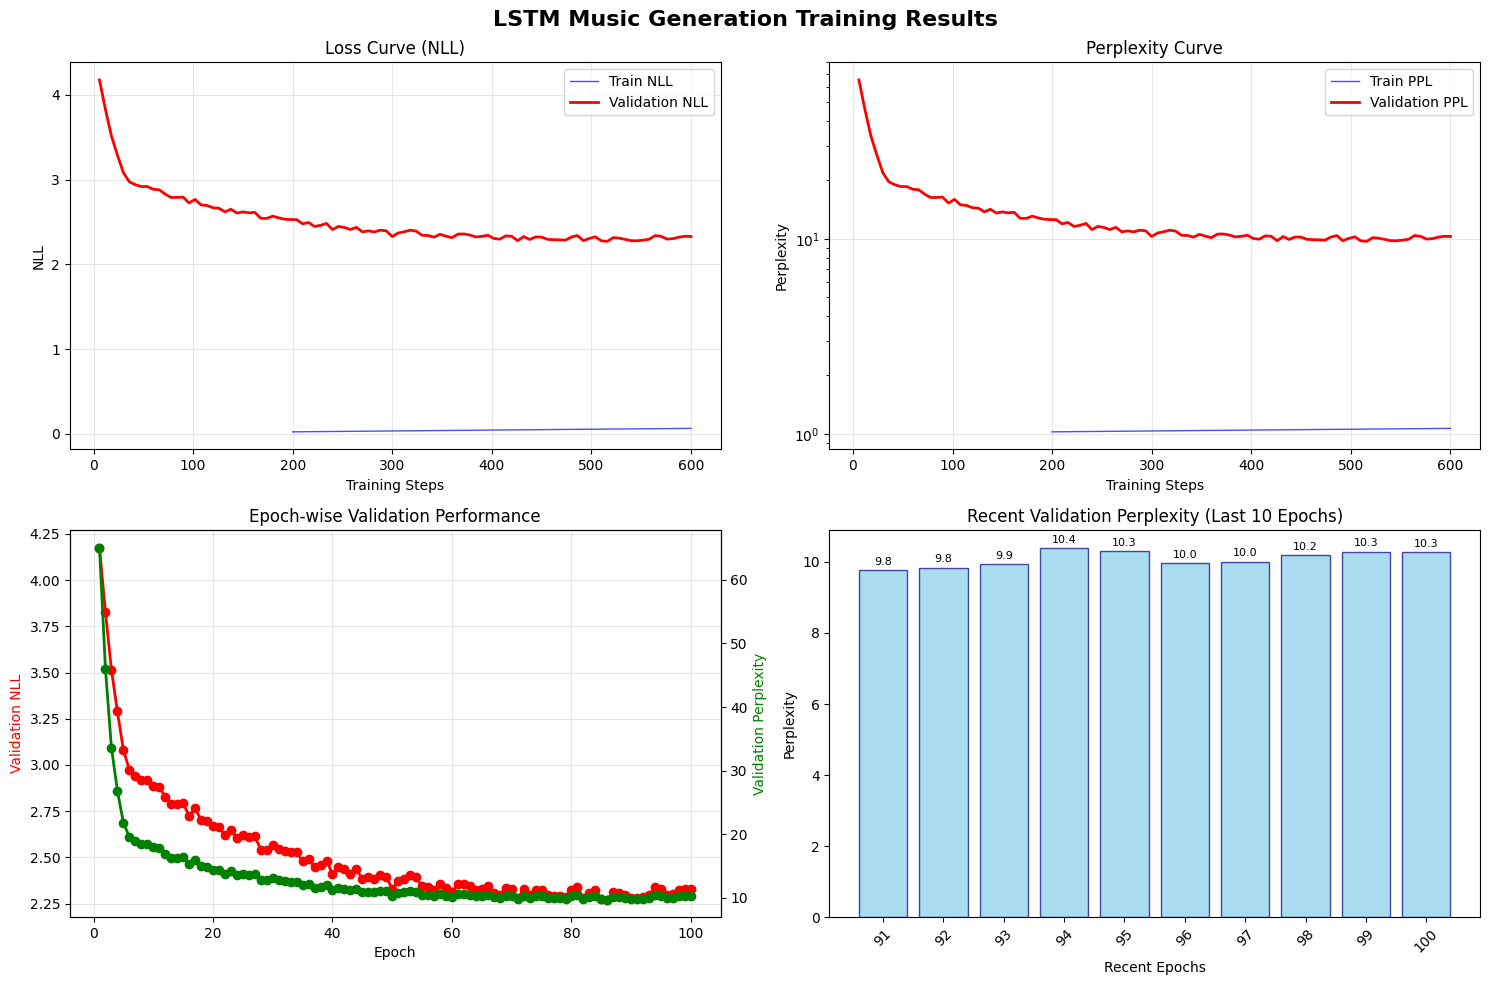


=== 상세 분석 ===


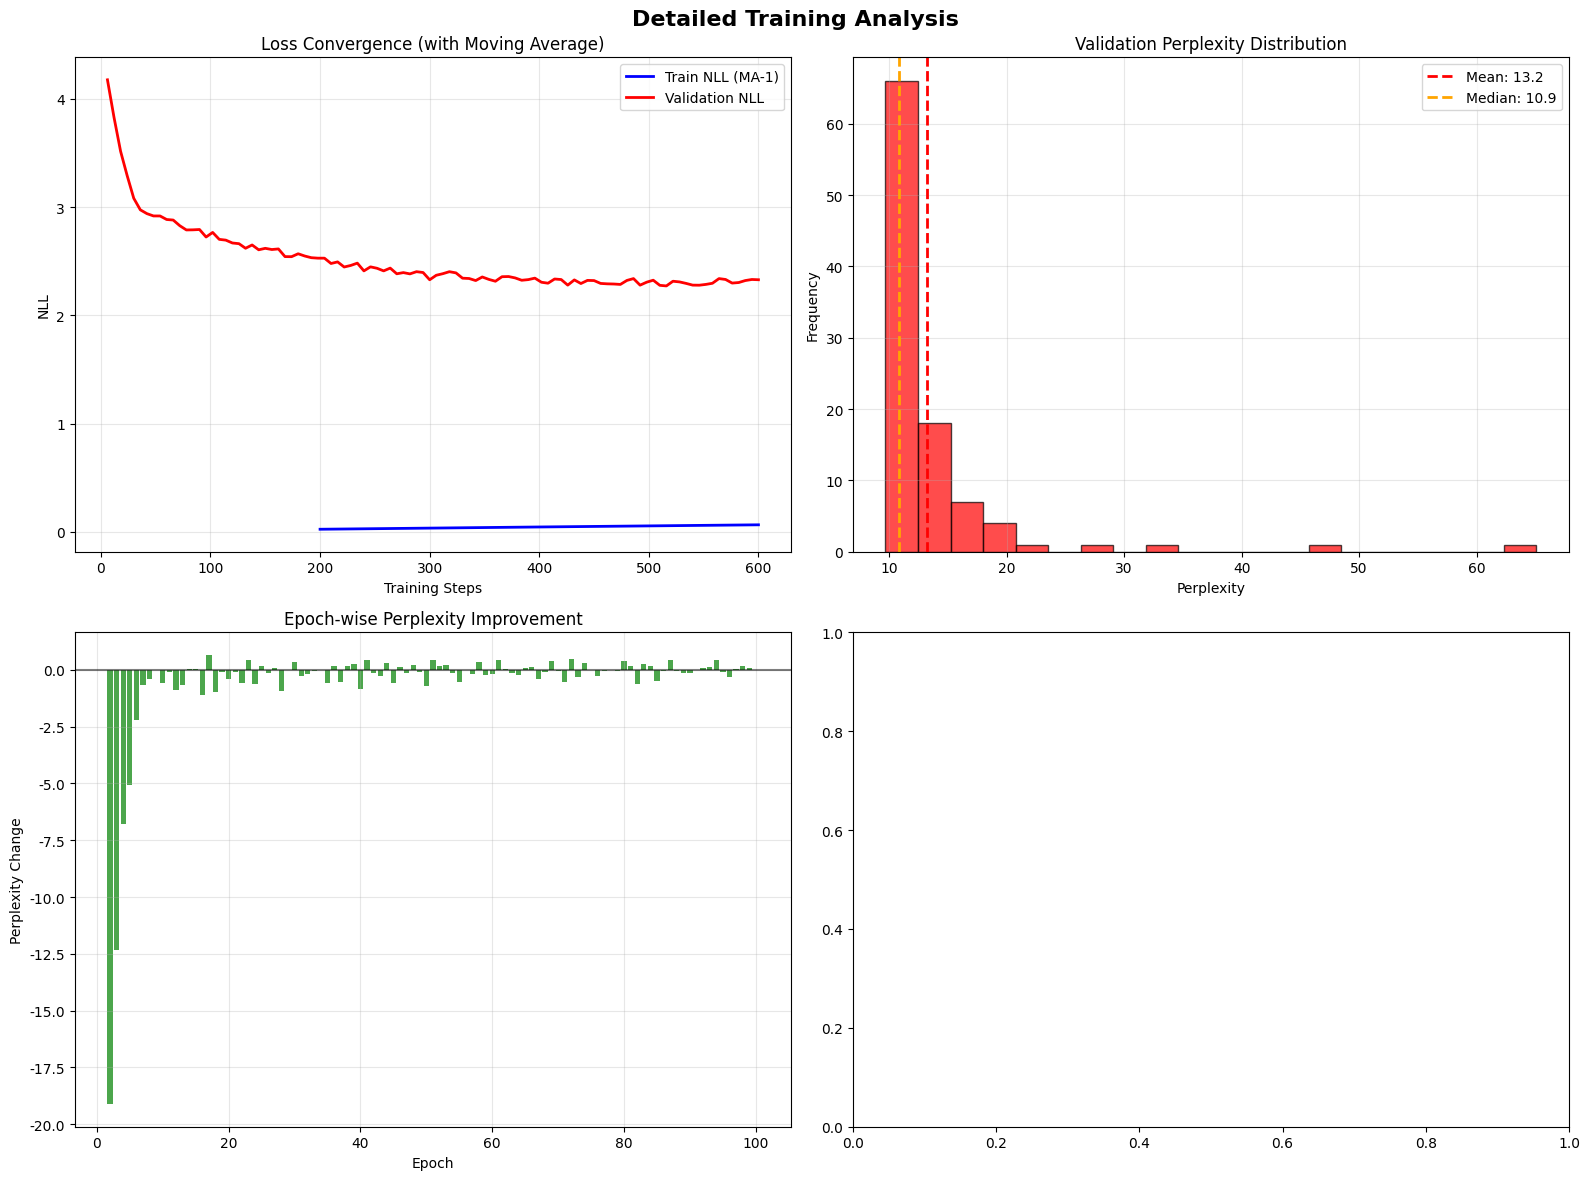

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def _read_log_safe(log_path):
    if not os.path.exists(log_path):
        raise FileNotFoundError(f"로그 파일을 찾을 수 없습니다: {log_path}")
    # 잘못된 행 스킵, 파이썬 엔진 사용
    df = pd.read_csv(
        log_path,
        engine="python",
        on_bad_lines="skip"
    )
    # 필요한 컬럼만 남기기 (여분 헤더/깨진 행 제거)
    keep = [c for c in ["step", "split", "nll", "ppl"] if c in df.columns]
    df = df[keep]
    # 숫자형 강제 변환
    if "step" in df.columns:
        df["step"] = pd.to_numeric(df["step"], errors="coerce")
    if "nll" in df.columns:
        df["nll"] = pd.to_numeric(df["nll"], errors="coerce")
    if "ppl" in df.columns:
        df["ppl"] = pd.to_numeric(df["ppl"], errors="coerce")
    # 유효한 행만
    df = df.dropna(subset=["step", "split", "nll", "ppl"])
    # step 정렬
    df = df.sort_values("step").reset_index(drop=True)
    return df

def plot_training_curves(log_path=f"{LOG_DIR}/train_val_curve.csv", save_path=None):
    df = _read_log_safe(log_path)

    train_data = df[df['split'] == 'train']
    val_data   = df[df['split'].str.contains('val', na=False)]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('LSTM Music Generation Training Results', fontsize=16, fontweight='bold')

    # 1) NLL
    ax1 = axes[0, 0]
    if len(train_data): ax1.plot(train_data['step'], train_data['nll'], 'b-', label='Train NLL', alpha=0.7, linewidth=1)
    if len(val_data):   ax1.plot(val_data['step'],   val_data['nll'],   'r-', label='Validation NLL', linewidth=2)
    ax1.set_xlabel('Training Steps'); ax1.set_ylabel('NLL'); ax1.set_title('Loss Curve (NLL)')
    ax1.legend(); ax1.grid(True, alpha=0.3)

    # 2) PPL
    ax2 = axes[0, 1]
    if len(train_data): ax2.plot(train_data['step'], train_data['ppl'], 'b-', label='Train PPL', alpha=0.7, linewidth=1)
    if len(val_data):   ax2.plot(val_data['step'],   val_data['ppl'],   'r-', label='Validation PPL', linewidth=2)
    ax2.set_xlabel('Training Steps'); ax2.set_ylabel('Perplexity'); ax2.set_title('Perplexity Curve')
    ax2.legend(); ax2.grid(True, alpha=0.3); ax2.set_yscale('log')

    # 3) Epoch-wise validation (raw string으로 정규식)
    ax3 = axes[1, 0]
    epoch_val_data = df[df['split'].str.contains('val_ep', na=False)].copy()
    if len(epoch_val_data):
        epoch_val_data['epoch'] = epoch_val_data['split'].str.extract(r'val_ep(\d+)').astype(int)
        epoch_val_data = epoch_val_data.sort_values('epoch')
        ax3.plot(epoch_val_data['epoch'], epoch_val_data['nll'], 'ro-', label='Val NLL', linewidth=2, markersize=6)
        ax3_twin = ax3.twinx()
        ax3_twin.plot(epoch_val_data['epoch'], epoch_val_data['ppl'], 'go-', label='Val PPL', linewidth=2, markersize=6)
        ax3.set_xlabel('Epoch'); ax3.set_ylabel('Validation NLL', color='red')
        ax3_twin.set_ylabel('Validation Perplexity', color='green')
        ax3.set_title('Epoch-wise Validation Performance'); ax3.grid(True, alpha=0.3)

    # 4) 최근 10 에폭 PPL
    ax4 = axes[1, 1]
    if len(epoch_val_data):
        recent = epoch_val_data.tail(10)
        x = np.arange(len(recent))
        bars = ax4.bar(x, recent['ppl'], alpha=0.7, color='skyblue', edgecolor='navy')
        ax4.set_xlabel('Recent Epochs'); ax4.set_ylabel('Perplexity')
        ax4.set_title('Recent Validation Perplexity (Last 10 Epochs)')
        ax4.set_xticks(x); ax4.set_xticklabels(recent['epoch'], rotation=45)
        for bar, v in zip(bars, recent['ppl']):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    if save_path is None:
        save_path = os.path.join(LOG_DIR, 'training_curves.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"그래프가 저장되었습니다: {save_path}")
    plt.show()

def plot_detailed_analysis(log_path=f"{LOG_DIR}/train_val_curve.csv"):
    df = _read_log_safe(log_path)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Detailed Training Analysis', fontsize=16, fontweight='bold')

    # 1) 이동평균 손실
    ax1 = axes[0, 0]
    train_data = df[df['split'] == 'train']
    val_data   = df[df['split'].str.contains('val', na=False)]
    if len(train_data):
        window = max(1, len(train_data) // 20)
        smooth = train_data['nll'].rolling(window=window, center=True).mean()
        ax1.plot(train_data['step'], smooth, 'b-', linewidth=2, label=f'Train NLL (MA-{window})')
        ax1.plot(train_data['step'], train_data['nll'], 'b-', alpha=0.3, linewidth=0.5)
    if len(val_data):
        ax1.plot(val_data['step'], val_data['nll'], 'r-', linewidth=2, label='Validation NLL')
    ax1.set_xlabel('Training Steps'); ax1.set_ylabel('NLL'); ax1.set_title('Loss Convergence (with Moving Average)')
    ax1.legend(); ax1.grid(True, alpha=0.3)

    # 2) Val PPL 분포
    ax2 = axes[0, 1]
    val_only = df[df['split'].str.contains('val', na=False)]
    if len(val_only):
        ax2.hist(val_only['ppl'], bins=20, alpha=0.7, color='red', edgecolor='black')
        ax2.axvline(val_only['ppl'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {val_only["ppl"].mean():.1f}')
        ax2.axvline(val_only['ppl'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {val_only["ppl"].median():.1f}')
    ax2.set_xlabel('Perplexity'); ax2.set_ylabel('Frequency'); ax2.set_title('Validation Perplexity Distribution')
    ax2.legend(); ax2.grid(True, alpha=0.3)

    # 3) 에폭별 개선률
    ax3 = axes[1, 0]
    epoch_val = df[df['split'].str.contains('val_ep', na=False)].copy()
    if len(epoch_val):
        epoch_val['epoch'] = epoch_val['split'].str.extract(r'val_ep(\d+)').astype(int)
        epoch_val = epoch_val.sort_values('epoch')
        epoch_val['ppl_impr'] = epoch_val['ppl'].diff()
        ax3.bar(epoch_val['epoch'][1:], epoch_val['ppl_impr'][1:], alpha=0.7, color='green')
        ax3.axhline(0, color='black', linestyle='-', alpha=0.5)
        ax3.set_xlabel('Epoch'); ax3.set_ylabel('Perplexity Change'); ax3.set_title('Epoch-wise Perplexity Improvement')
        ax3.grid(True, alpha=0.3)

    # 4) 학습 안정성
    ax4 = axes[1, 1]
    if len(train_data) > 10:
        group_size = max(1, len(train_data) // 10)
        groups = [train_data['nll'].iloc[i:i+group_size] for i in range(0, len(train_data), group_size)]
        stds = [g.std() for g in groups if len(g) > 1]
        xs = [i * group_size for i in range(len(stds))]
        ax4.plot(xs, stds, 'bo-', linewidth=2, markersize=6)
        ax4.set_xlabel('Training Steps (Grouped)'); ax4.set_ylabel('NLL Std'); ax4.set_title('Training Stability (Loss Variance)')
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("=== 학습 곡선 시각화 ===")
plot_training_curves()

print("\n=== 상세 분석 ===")
plot_detailed_analysis()

## 모델링 (2)
- 어텐션
- 계층적 구조

In [34]:
# ===== 개선버전: LSTM(+Attention) 실험 프레임 (MPS/CPU 전용) =====
import os, math, csv, time, json, random, itertools
from dataclasses import dataclass
from typing import Optional, Dict, Any, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

# AMP(CUDA) 모듈은 선택 임포트: MPS/CPU에서는 사용 안 함
try:
    from torch.cuda.amp import autocast, GradScaler
except Exception:
    autocast, GradScaler = None, None

# ========== 경로/디바이스 ==========
PROJ = r"C:\Users\seon\Downloads\aria-midi-v1-unique-ext\chopin_dataset"
CKPT_DIR    = f"{PROJ}/ckpt"
LOG_DIR     = f"{PROJ}/logs"
SAMPLES_DIR = f"{PROJ}/samples"
RESULTS_DIR = f"{PROJ}/results"
for d in [CKPT_DIR, LOG_DIR, SAMPLES_DIR, RESULTS_DIR]:
    os.makedirs(d, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

# ===== 필수 토큰 상수 (폴백) =====
try: PAD_ID
except NameError: PAD_ID = 0
try: BOS_ID
except NameError: BOS_ID = 1
try: EOS_ID
except NameError: EOS_ID = 2
try: VOCAB_SIZE
except NameError: VOCAB_SIZE = 3 + 16 + 16 + 128 + 128  # PAD/BOS/EOS + VEL(16) + TS(16) + ON(128) + OFF(128)

# ========== 설정 ==========
@dataclass
class TrainConfig:
    vocab_size: int = VOCAB_SIZE
    pad_id: int = PAD_ID
    d_model: int = 512
    lstm_hidden: int = 768
    lstm_layers: int = 2
    max_len: int = 512

    # lr/opt
    lr: float = 3e-4
    weight_decay: float = 0.01
    epochs: int = 50
    grad_clip: float = 1.0

    # AMP는 CUDA 전용 → MPS/CPU에서는 비활성화
    amp: bool = torch.cuda.is_available()

    # logging
    log_every: int = 200
    val_every: int = 1000
    seed: int = 42

    # dropout (분리)
    dropout_emb: float = 0.1
    dropout_lstm: float = 0.25
    dropout_attn: float = 0.1
    dropout_ffn: float = 0.1

    # Attention 옵션
    use_attention: bool = False
    num_attention_heads: int = 8

    # 랜덤 서치
    n_trials: int = 5   # 실험 개수 (시간 절약용 소수)
    # 샘플링
    default_temperature: float = 1.0
    default_top_k: int = 50
    default_top_p: float = 0.0
    default_no_repeat_ngram: int = 0

cfg = TrainConfig()

def set_seed(seed: int):
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # CUDA 시드/백엔드는 사용하지 않음 (MPS/CPU 전용)

set_seed(cfg.seed)

# ========== 모델 ==========
class EventLSTM(nn.Module):
    def __init__(self, vocab_size, d_model=512, hidden=768, layers=2,
                 dropout_emb=0.1, dropout_lstm=0.25, pad_id=0):
        super().__init__()
        self.use_attention = False
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.drop_emb = nn.Dropout(dropout_emb)
        self.lstm = nn.LSTM(
            input_size=d_model, hidden_size=hidden, num_layers=layers,
            batch_first=True, dropout=dropout_lstm if layers > 1 else 0.0
        )
        self.norm = nn.LayerNorm(hidden)
        self.drop_out = nn.Dropout(dropout_lstm)
        self.head = nn.Linear(hidden, vocab_size)

    def forward(self, x: torch.Tensor, hidden: Optional[Tuple[torch.Tensor,torch.Tensor]]=None):
        x = self.drop_emb(self.embed(x))      # (B,T,d_model)
        out, hidden = self.lstm(x, hidden)    # (B,T,H)
        out = self.drop_out(self.norm(out))   # (B,T,H)
        logits = self.head(out)               # (B,T,V)
        return logits, hidden

class EventLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, d_model=512, hidden=768, layers=2,
                 dropout_emb=0.1, dropout_lstm=0.25,
                 num_heads=8, dropout_attn=0.1, dropout_ffn=0.1, pad_id=0):
        super().__init__()
        self.use_attention = True
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.drop_emb = nn.Dropout(dropout_emb)

        self.lstm = nn.LSTM(
            input_size=d_model, hidden_size=hidden, num_layers=layers,
            batch_first=True, dropout=dropout_lstm if layers > 1 else 0.0
        )
        self.attn = nn.MultiheadAttention(embed_dim=hidden, num_heads=num_heads,
                                          dropout=dropout_attn, batch_first=True)
        self.dropout_attn = nn.Dropout(dropout_attn)
        self.dropout_ffn  = nn.Dropout(dropout_ffn)

        self.norm1 = nn.LayerNorm(hidden)
        self.norm2 = nn.LayerNorm(hidden)
        self.ffn = nn.Sequential(
            nn.Linear(hidden, 4*hidden),
            nn.GELU(),
            nn.Linear(4*hidden, hidden)
        )
        self.head = nn.Linear(hidden, vocab_size)

    def _causal_mask(self, T: int, device):
        return torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)

    def forward(self, x: torch.Tensor, hidden: Optional[Tuple[torch.Tensor,torch.Tensor]]=None):
        x = self.drop_emb(self.embed(x))            # (B,T,d_model)
        lstm_out, hidden = self.lstm(x, hidden)     # (B,T,H)

        T = lstm_out.size(1)
        attn_mask = self._causal_mask(T, lstm_out.device)  # (T,T) boolean

        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out, attn_mask=attn_mask)  # (B,T,H)
        y = self.norm1(lstm_out + self.dropout_attn(attn_out))                      # (B,T,H)

        ffn_out = self.ffn(y)                                   # (B,T,H)
        y = self.norm2(y + self.dropout_ffn(ffn_out))           # (B,T,H)

        logits = self.head(y)                                   # (B,T,V)
        return logits, hidden

# ========== 유틸 ==========
def count_params(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

def perplexity(nll):
    try: return math.exp(nll)
    except OverflowError: return float("inf")

def save_checkpoint(model, opt, scaler, step, path):
    torch.save({
        "model": model.state_dict(),
        "opt": opt.state_dict(),
        "scaler": None,  # MPS/CPU에서는 AMP/스케일러 미사용
        "step": step
    }, path)

# nucleus(top-p) & top-k & no-repeat-ngram
def _apply_sampling_filters(logits: torch.Tensor, top_k: int=0, top_p: float=0.0) -> torch.Tensor:
    probs = torch.softmax(logits, dim=-1)

    if top_k and top_k > 0 and top_k < probs.numel():
        topv, topi = torch.topk(probs, k=top_k)
        filtered = torch.full_like(probs, 0.0)
        filtered.scatter_(0, topi, topv)
        probs = filtered

    if top_p and 0.0 < top_p < 1.0:
        sorted_probs, sorted_idx = torch.sort(probs, descending=True)
        cumsum = torch.cumsum(sorted_probs, dim=-1)
        mask = cumsum > top_p
        mask[0] = False
        sorted_probs[mask] = 0.0
        probs = torch.zeros_like(probs)
        probs.scatter_(0, sorted_idx, sorted_probs)

    s = probs.sum()
    if s.item() > 0:
        probs = probs / s
    else:
        probs = torch.full_like(probs, 1.0 / probs.numel())
    return probs

def _forbidden_next_tokens_by_ngram(prefix: List[int], n: int) -> set:
    if n <= 1 or len(prefix) < n-1:
        return set()
    mapping = {}
    for i in range(len(prefix)-n+1):
        key = tuple(prefix[i:i+n-1])
        nxt = prefix[i+n-1]
        mapping.setdefault(key, set()).add(nxt)
    key = tuple(prefix[-(n-1):])
    return mapping.get(key, set())

@torch.no_grad()
def sample_and_save(model, start_token=BOS_ID, max_tokens=1024,
                    temperature: float=1.0, top_k: Optional[int]=50, top_p: float=0.0,
                    no_repeat_ngram_size: int=0,
                    out_midi_path: Optional[str]=None, aux_for_detok: Optional[dict]=None):
    model.eval()
    toks: List[int] = [start_token]
    hidden = None

    for _ in range(max_tokens-1):
        if getattr(model, "use_attention", False):
            x = torch.tensor(toks[-cfg.max_len:], dtype=torch.long, device=device).unsqueeze(0)
            logits, hidden = model(x, hidden=None)
            last = logits[:, -1, :].squeeze(0)
        else:
            x = torch.tensor([[toks[-1]]], dtype=torch.long, device=device)
            logits, hidden = model(x, hidden)
            last = logits.squeeze(0).squeeze(0)

        last = last / max(1e-6, temperature)

        forbids = _forbidden_next_tokens_by_ngram(toks, no_repeat_ngram_size) if no_repeat_ngram_size > 1 else set()
        probs = _apply_sampling_filters(last, top_k=top_k or 0, top_p=top_p)

        if forbids:
            probs[list(forbids)] = 0.0
            s = probs.sum()
            probs = probs / s if s.item() > 0 else torch.full_like(probs, 1.0 / probs.numel())

        next_id = int(torch.multinomial(probs, num_samples=1).item())
        toks.append(next_id)
        if next_id == EOS_ID:
            break

    if out_midi_path is not None and aux_for_detok is not None:
        try:
            detokenize_to_midi_file(toks, aux_for_detok, out_midi_path)
        except Exception as e:
            print("[WARN] detokenize failed:", e)

    return toks

# ========== 학습/검증 루프 ==========
def append_log(csv_path, row: Dict[str, Any]):
    write_header = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["step", "split", "nll", "ppl"])
        if write_header: w.writeheader()
        w.writerow(row)

def train_one_epoch(model, dl, opt, scheduler, scaler, ce, step0=0, log_path=f"{LOG_DIR}/train_val_curve.csv",
                    val_dl=None):
    model.train()
    running_loss, step = 0.0, step0
    t0 = time.time()

    for xb, yb, mb in dl:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)

        # AMP 비활성화 경로 (MPS/CPU)
        logits, _ = model(xb)
        loss = ce(logits.reshape(-1, cfg.vocab_size), yb.reshape(-1))
        loss.backward()
        if cfg.grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        opt.step()

        if scheduler is not None:
            scheduler.step()

        step += 1
        running_loss += float(loss.item())

        if step % cfg.log_every == 0:
            avg_nll = running_loss / cfg.log_every
            ppl = perplexity(avg_nll)
            print(f"[train] step {step}  nll={avg_nll:.3f}  ppl={ppl:.1f}  ({time.time()-t0:.1f}s)")
            append_log(log_path, {"step": step, "split": "train", "nll": avg_nll, "ppl": ppl})
            running_loss = 0.0

        if (val_dl is not None) and (step % cfg.val_every == 0):
            nll, ppl = evaluate(model, val_dl)
            print(f"[val]   step {step}  nll={nll:.3f}  ppl={ppl:.1f}")
            append_log(log_path, {"step": step, "split": "val", "nll": nll, "ppl": ppl})
            model.train()
    return step

@torch.no_grad()
def evaluate(model, dl):
    model.eval()
    ce = nn.CrossEntropyLoss(ignore_index=cfg.pad_id, reduction="none")
    total_loss, total_tokens = 0.0, 0

    for xb, yb, mb in dl:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        logits, _ = model(xb)  # (B,T,V)
        V = cfg.vocab_size
        loss_vec = ce(logits.reshape(-1, V), yb.reshape(-1))  # (B*T,)
        mask = (yb.reshape(-1) != cfg.pad_id)
        total_loss += float(loss_vec[mask].sum().item())
        total_tokens += int(mask.sum().item())

    nll = total_loss / max(1, total_tokens)
    ppl = perplexity(nll)
    return nll, ppl

# ========== 랜덤 서치 ==========
def sample_config_space() -> Dict[str, Any]:
    return {
        "use_attention": random.choice([False, True]),
        "num_attention_heads": random.choice([4, 8, 16]),
        "lr": random.choice([1e-4, 3e-4, 1e-3]),
        "weight_decay": random.choice([0.01, 0.1, 0.5]),
        "dropout_emb": random.choice([0.05, 0.1, 0.2]),
        "dropout_lstm": random.choice([0.2, 0.25, 0.3]),
        "dropout_attn": random.choice([0.05, 0.1, 0.2]),
        "dropout_ffn": random.choice([0.05, 0.1, 0.2]),
    }

def build_model_from_cfg() -> nn.Module:
    if cfg.use_attention:
        model = EventLSTMWithAttention(
            vocab_size=cfg.vocab_size,
            d_model=cfg.d_model,
            hidden=cfg.lstm_hidden,
            layers=cfg.lstm_layers,
            dropout_emb=cfg.dropout_emb,
            dropout_lstm=cfg.dropout_lstm,
            num_heads=cfg.num_attention_heads,
            dropout_attn=cfg.dropout_attn,
            dropout_ffn=cfg.dropout_ffn,
            pad_id=cfg.pad_id
        ).to(device)
    else:
        model = EventLSTM(
            vocab_size=cfg.vocab_size,
            d_model=cfg.d_model,
            hidden=cfg.lstm_hidden,
            layers=cfg.lstm_layers,
            dropout_emb=cfg.dropout_emb,
            dropout_lstm=cfg.dropout_lstm,
            pad_id=cfg.pad_id
        ).to(device)
    return model

def run_random_search(train_dl, val_dl, n_trials: int = None):
    n_trials = n_trials or cfg.n_trials
    results = []
    best_perplexity = float("inf")
    best_config = None

    print(f"총 {n_trials}개 랜덤 서치를 실행합니다...")

    for i in range(1, n_trials+1):
        conf = sample_config_space()
        cfg.use_attention      = conf["use_attention"]
        cfg.num_attention_heads= conf["num_attention_heads"]
        cfg.lr                 = conf["lr"]
        cfg.weight_decay       = conf["weight_decay"]
        cfg.dropout_emb        = conf["dropout_emb"]
        cfg.dropout_lstm       = conf["dropout_lstm"]
        cfg.dropout_attn       = conf["dropout_attn"]
        cfg.dropout_ffn        = conf["dropout_ffn"]

        print(f"\n=== 실험 {i}/{n_trials} ===")
        print(f"설정: {conf}")

        set_seed(cfg.seed + i)
        model = build_model_from_cfg()
        print(f"모델 파라미터: {count_params(model)/1e6:.2f}M")

        opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        steps_per_epoch = max(1, len(train_dl))
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, cfg.epochs * steps_per_epoch))
        scaler = None  # AMP 미사용
        ce = nn.CrossEntropyLoss(ignore_index=cfg.pad_id, reduction="mean")

        global_step = 0
        best_val_ppl = float("inf")

        for ep in range(1, cfg.epochs + 1):
            global_step = train_one_epoch(model, train_dl, opt, scheduler, scaler, ce, step0=global_step, val_dl=val_dl)
            nll, ppl = evaluate(model, val_dl)
            print(f"[val @epoch{ep}] nll={nll:.3f}  ppl={ppl:.2f}")
            if ppl < best_val_ppl:
                best_val_ppl = ppl

        results.append({
            "config": conf,
            "best_val_perplexity": float(best_val_ppl),
            "model_params": int(count_params(model)),
            "experiment_id": i
        })
        print(f"최고 검증 Perplexity: {best_val_ppl:.2f}")

        if best_val_ppl < best_perplexity:
            best_perplexity = best_val_ppl
            best_config = conf
            print(f"★ 새로운 최고 성능! Perplexity: {best_perplexity:.2f}")

    results_file = f"{RESULTS_DIR}/random_search_results.json"
    with open(results_file, "w") as f:
        json.dump(results, f, indent=2)

    print("\n=== 랜덤 서치 완료 ===")
    print(f"총 {len(results)}개 실험 완료")
    print(f"최고 성능: Perplexity {best_perplexity:.2f}")
    print(f"최고 설정: {best_config}")
    print(f"결과 저장: {results_file}")

    analyze_results(results)
    return results, best_config

def analyze_results(results: List[Dict[str,Any]]):
    print("\n=== 결과 분석 ===")
    attn = [r for r in results if r["config"]["use_attention"]]
    base = [r for r in results if not r["config"]["use_attention"]]
    if attn and base:
        avg_attn = sum(r["best_val_perplexity"] for r in attn) / len(attn)
        avg_base = sum(r["best_val_perplexity"] for r in base) / len(base)
        imp = (avg_base - avg_attn) / max(1e-9, avg_base) * 100.0
        print(f"Baseline 평균 PPL: {avg_base:.2f}")
        print(f"Attention 평균 PPL: {avg_attn:.2f}")
        print(f"개선율: {imp:.1f}%")

    top5 = sorted(results, key=lambda x: x["best_val_perplexity"])[:5]
    print("\n상위 5개 결과:")
    for i, r in enumerate(top5, 1):
        print(f"{i}. PPL {r['best_val_perplexity']:.2f}  | 설정: {r['config']}")

# ========== 메인 ==========
if __name__ == "__main__":
    print("🔥 LSTM 업그레이드 1차: Attention + 랜덤 서치")
    print(f"디바이스: {device}")
    print(f"VOCAB_SIZE: {VOCAB_SIZE}")
    # train_dl, val_dl 은 사전에 준비되어 있어야 합니다.
    results, best_config = run_random_search(train_dl, val_dl, n_trials=cfg.n_trials)

    # 샘플 생성 예시
    # sample_and_save(model, start_token=BOS_ID, max_tokens=1024,
    #                 temperature=cfg.default_temperature, top_k=cfg.default_top_k,
    #                 top_p=cfg.default_top_p, no_repeat_ngram_size=cfg.default_no_repeat_ngram,
    #                 out_midi_path=f"{SAMPLES_DIR}/sample.mid", aux_for_detok=aux_dict)

Using device: cuda
🔥 LSTM 업그레이드 1차: Attention + 랜덤 서치
디바이스: cuda
VOCAB_SIZE: 291
총 5개 랜덤 서치를 실행합니다...

=== 실험 1/5 ===
설정: {'use_attention': False, 'num_attention_heads': 4, 'lr': 0.001, 'weight_decay': 0.1, 'dropout_emb': 0.05, 'dropout_lstm': 0.2, 'dropout_attn': 0.05, 'dropout_ffn': 0.2}
모델 파라미터: 9.04M
[val @epoch1] nll=3.954  ppl=52.12
[val @epoch2] nll=3.270  ppl=26.31
[val @epoch3] nll=3.032  ppl=20.74
[val @epoch4] nll=2.868  ppl=17.61
[val @epoch5] nll=2.884  ppl=17.89
[val @epoch6] nll=2.839  ppl=17.09
[val @epoch7] nll=2.785  ppl=16.20
[val @epoch8] nll=2.735  ppl=15.41
[val @epoch9] nll=2.728  ppl=15.31
[val @epoch10] nll=2.659  ppl=14.29
[val @epoch11] nll=2.634  ppl=13.92
[val @epoch12] nll=2.589  ppl=13.32
[val @epoch13] nll=2.577  ppl=13.16
[val @epoch14] nll=2.569  ppl=13.05
[val @epoch15] nll=2.562  ppl=12.97
[val @epoch16] nll=2.519  ppl=12.42
[val @epoch17] nll=2.509  ppl=12.29
[val @epoch18] nll=2.509  ppl=12.30
[val @epoch19] nll=2.449  ppl=11.58
[val @epoch20] nll=

In [35]:
# === 베스트 설정으로 단일 학습 → 베스트 가중치 저장/로드 → 샘플 생성/재생 (Windows + CUDA/CPU) ===
import os, json, time
from IPython.display import Audio, display
import torch
import torch.nn as nn

# ---- 디바이스/AMP ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    from torch.cuda.amp import autocast, GradScaler
except Exception:
    autocast, GradScaler = None, None
use_amp = (device.type == "cuda") and (autocast is not None) and (GradScaler is not None)

# ---- 경로 (앞선 셀에서 만든 폴더 재사용 가정) ----
BEST_CKPT_PATH = f"{CKPT_DIR}/best_model.pt"
RESULTS_JSON   = f"{RESULTS_DIR}/random_search_results.json"

# 0) best_config 확보: 변수 없으면 results.json에서 최저 PPL 자동 선택
try:
    best_config  # 이미 존재하면 그대로 사용
except NameError:
    if not os.path.exists(RESULTS_JSON):
        raise FileNotFoundError(f"결과 파일이 없습니다: {RESULTS_JSON} (먼저 랜덤서치 또는 결과 저장 필요)")
    with open(RESULTS_JSON, "r") as f:
        results = json.load(f)
    if not results:
        raise RuntimeError("results.json이 비어 있습니다. 랜덤서치를 먼저 실행하세요.")
    best_row = min(results, key=lambda r: r["best_val_perplexity"])
    best_config = best_row["config"]
print("[best_config]", best_config)

# 1) cfg 적용
cfg.use_attention       = best_config['use_attention']
cfg.num_attention_heads = best_config['num_attention_heads']
cfg.lr                  = best_config['lr']
cfg.weight_decay        = best_config['weight_decay']
cfg.dropout_emb         = best_config['dropout_emb']
cfg.dropout_lstm        = best_config['dropout_lstm']
cfg.dropout_attn        = best_config['dropout_attn']
cfg.dropout_ffn         = best_config['dropout_ffn']
cfg.amp                 = use_amp  # CUDA면 True

# 2) 모델/옵티마이저/스케줄러
best_model = build_model_from_cfg()
opt = torch.optim.AdamW(best_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
steps_per_epoch = max(1, len(train_dl))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, cfg.epochs * steps_per_epoch))
scaler = GradScaler(enabled=use_amp)
ce = nn.CrossEntropyLoss(ignore_index=cfg.pad_id, reduction="mean")

# 3) 단일 학습 루프 + 최고 PPL 가중치만 저장
best_val_ppl = float("inf")
global_step = 0
for ep in range(1, cfg.epochs + 1):
    global_step = train_one_epoch(best_model, train_dl, opt, scheduler, scaler, ce,
                                  step0=global_step, val_dl=val_dl)
    nll, ppl = evaluate(best_model, val_dl)
    print(f"[single-train @epoch{ep}] nll={nll:.3f}  ppl={ppl:.2f}")
    if ppl < best_val_ppl:
        best_val_ppl = ppl
        torch.save(best_model.state_dict(), BEST_CKPT_PATH)
        print(f"✔ 베스트 갱신: PPL={best_val_ppl:.2f}  → 저장: {BEST_CKPT_PATH}")

# 4) 가장 좋은 가중치 로드(안전)
best_model.load_state_dict(torch.load(BEST_CKPT_PATH, map_location=device))
best_model.eval()
print("✅ 베스트 모델 준비 완료")

# 5) 토큰 생성 → MIDI/WAV 저장 → 재생
toks = sample_and_save(
    best_model,
    start_token=BOS_ID,
    max_tokens=512,
    temperature=cfg.default_temperature,
    top_k=cfg.default_top_k,
    out_midi_path=None,  # detokenize 단계에서 저장
    aux_for_detok={"step_sec": 0.5/64, "program": 0}
)

# 파일 경로
os.makedirs(SAMPLES_DIR, exist_ok=True)
mid = os.path.join(SAMPLES_DIR, f"best_{int(time.time())}.mid")
wav = mid.replace(".mid", ".wav")

# detokenize (BOS/PAD 제거)
toks = [t for t in toks if t not in (PAD_ID, BOS_ID)]
detokenize_to_midi_file(toks, {"step_sec": 0.5/64, "program": 0}, mid)

# ---- Windows: SoundFont & FluidSynth 경로 후보 ----
# 1) SoundFont(.sf2) 후보 (원하는 경로로 수정하세요)
sf2_candidates = [
    r"C:\Users\seon\Downloads\soundfonts\FluidR3_GM.sf2",
    r"C:\SoundFonts\FluidR3_GM.sf2",
]

# 2) fluidsynth.exe 경로(Zip 해제한 폴더의 bin)
#   https://github.com/FluidSynth/fluidsynth/releases 에서 Windows zip 받기
fluidsynth_bin_candidates = [
    r"C:\Users\seon\Downloads\fluidsynth-2.3.4-win64\bin",
    r"C:\Tools\fluidsynth\bin",
]

# PATH에 fluidsynth bin 추가(존재하는 것만)
for p in fluidsynth_bin_candidates:
    if os.path.isdir(p):
        os.environ["PATH"] += os.pathsep + p

sf2 = next((p for p in sf2_candidates if os.path.exists(p)), None)

try:
    from midi2audio import FluidSynth
    if sf2 is None:
        raise FileNotFoundError("SoundFont(.sf2) not found in candidates. sf2_candidates를 수정하세요.")
    FluidSynth(sf2).midi_to_audio(mid, wav)
    display(Audio(wav))
    print("MIDI:", mid, "| WAV:", wav)
except Exception as e:
    print("[WARN] WAV 변환 건너뜀:", e)
    print("→ MIDI는 저장되었습니다:", mid)
    print("  Windows: fluidsynth Windows zip 다운로드 후 bin 경로를 PATH에 추가하고, sf2 경로를 올바르게 지정하세요.")


[best_config] {'use_attention': True, 'num_attention_heads': 16, 'lr': 0.001, 'weight_decay': 0.5, 'dropout_emb': 0.05, 'dropout_lstm': 0.2, 'dropout_attn': 0.1, 'dropout_ffn': 0.05}


C:\Users\seon\AppData\Local\Temp\ipykernel_18772\302776209.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


[single-train @epoch1] nll=4.213  ppl=67.59
✔ 베스트 갱신: PPL=67.59  → 저장: C:\Users\seon\Downloads\aria-midi-v1-unique-ext\chopin_dataset/ckpt/best_model.pt
[single-train @epoch2] nll=3.718  ppl=41.20
✔ 베스트 갱신: PPL=41.20  → 저장: C:\Users\seon\Downloads\aria-midi-v1-unique-ext\chopin_dataset/ckpt/best_model.pt
[single-train @epoch3] nll=3.190  ppl=24.30
✔ 베스트 갱신: PPL=24.30  → 저장: C:\Users\seon\Downloads\aria-midi-v1-unique-ext\chopin_dataset/ckpt/best_model.pt
[single-train @epoch4] nll=2.978  ppl=19.66
✔ 베스트 갱신: PPL=19.66  → 저장: C:\Users\seon\Downloads\aria-midi-v1-unique-ext\chopin_dataset/ckpt/best_model.pt
[single-train @epoch5] nll=2.929  ppl=18.71
✔ 베스트 갱신: PPL=18.71  → 저장: C:\Users\seon\Downloads\aria-midi-v1-unique-ext\chopin_dataset/ckpt/best_model.pt
[single-train @epoch6] nll=2.853  ppl=17.34
✔ 베스트 갱신: PPL=17.34  → 저장: C:\Users\seon\Downloads\aria-midi-v1-unique-ext\chopin_dataset/ckpt/best_model.pt
[single-train @epoch7] nll=2.735  ppl=15.40
✔ 베스트 갱신: PPL=15.40  → 저장: C:\Users\se

### 결과

In [41]:
# 5) 토큰 생성 → MIDI/WAV 저장 → 재생
toks = sample_and_save(
    best_model,
    start_token=BOS_ID,
    max_tokens=1024,
    temperature=cfg.default_temperature,
    top_k=cfg.default_top_k,
    out_midi_path=None,  # detokenize 단계에서 저장
    aux_for_detok={"step_sec": 0.5/64, "program": 0}
)

# 파일 경로
os.makedirs(SAMPLES_DIR, exist_ok=True)
mid = os.path.join(SAMPLES_DIR, f"best_{int(time.time())}.mid")
wav = mid.replace(".mid", ".wav")

# detokenize (BOS/PAD 제거)
toks = [t for t in toks if t not in (PAD_ID, BOS_ID)]
detokenize_to_midi_file(toks, {"step_sec": 0.5/64, "program": 0}, mid)

# ---- Windows: SoundFont & FluidSynth 경로 후보 ----
# 1) SoundFont(.sf2) 후보 (원하는 경로로 수정하세요)
sf2_candidates = [
    r"C:\Users\seon\Downloads\soundfonts\FluidR3_GM.sf2",
    r"C:\SoundFonts\FluidR3_GM.sf2",
]

# 2) fluidsynth.exe 경로(Zip 해제한 폴더의 bin)
#   https://github.com/FluidSynth/fluidsynth/releases 에서 Windows zip 받기
fluidsynth_bin_candidates = [
    r"C:\Users\seon\Downloads\fluidsynth-2.3.4-win64\bin",
    r"C:\Tools\fluidsynth\bin",
]

# PATH에 fluidsynth bin 추가(존재하는 것만)
for p in fluidsynth_bin_candidates:
    if os.path.isdir(p):
        os.environ["PATH"] += os.pathsep + p

sf2 = next((p for p in sf2_candidates if os.path.exists(p)), None)

try:
    from midi2audio import FluidSynth
    if sf2 is None:
        raise FileNotFoundError("SoundFont(.sf2) not found in candidates. sf2_candidates를 수정하세요.")
    FluidSynth(sf2).midi_to_audio(mid, wav)
    display(Audio(wav))
    print("MIDI:", mid, "| WAV:", wav)
except Exception as e:
    print("[WARN] WAV 변환 건너뜀:", e)
    print("→ MIDI는 저장되었습니다:", mid)
    print("  Windows: fluidsynth Windows zip 다운로드 후 bin 경로를 PATH에 추가하고, sf2 경로를 올바르게 지정하세요.")


[WARN] WAV 변환 건너뜀: SoundFont(.sf2) not found in candidates. sf2_candidates를 수정하세요.
→ MIDI는 저장되었습니다: C:\Users\seon\Downloads\aria-midi-v1-unique-ext\chopin_dataset/samples\best_1757002518.mid
  Windows: fluidsynth Windows zip 다운로드 후 bin 경로를 PATH에 추가하고, sf2 경로를 올바르게 지정하세요.
